Analysis_for_ZION_part1
- So we decided to use data from Nasdaq. It seems more accurate than Yahoo Finance.
- The data covers only until April 2018. Let us down load data from 2000-01-01.
- To carry out cross-validation and hyperparameters tuning we will use 5-fold cross validataion. We will use slide window of 5 year (5*252) to train model; and validation of 21 days.
         - The last day of last validation period is 2017/12/31
         - Our test period (for purpose of perfromance reporting) is January 2018.
         - So for EDA (for example ACF and PACF, we will look at 6 year of data 2012-2017
       
- We will chose two stocks:
	- We will choose two in the same industry; they have long been public company – let say price available from about 2000.
	- Small size company: Zions Bancorporation (ZION) (About 689 in USA, Largest American companies by market capitalization (companiesmarketcap.com))
	- Medium size company: Fifth Third Bank (FITB) (About 302 in the USA)
    - We try to check the Efficient Market Hypothesis for small and medium stocks.

# Table of Content
## Step2: Data wrangling
2.1) Import necessary packages  
2.2)  
2.3) 

## Step3



# Step2: Data wrangling

## 2.1) Import necessary packages

In [1]:
%who

Interactive namespace is empty.


In [2]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as scs

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

from sklearn.preprocessing import FunctionTransformer

import talib # technical analysis library

from sklearn.model_selection import TimeSeriesSplit, cross_validate

## 2.2) Load data from hard disk

- We have downloaded data for ZION and saved in hard disk. Daily data from 2000/1/3 to 2018/3/27.
- Data dimension (4586, 12).

-If we use simple zion = pd.read_csv('../raw_data/zion.csv')
    - "Date" will be column with dtype object. We can convert it do datetime using pd.to_datetime(); and set it as index. But the index has dtype as Rangeindex (instead of DatetimeIndex as in original dataframe downloaded from Nasdaq).
- So we will follow book "TS Analysis with Python", ch2 to add more arguments to read_csv().
    - A better way, is to use Pickle to save Dataframe instead of using to_csv()
- Once the we have DatetimeIndex we can subset the dataset really easy. See https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/subset-time-series-data-python/    

In [3]:
# Read data back after restart computer. We will have more arguments here.
zion = pd.read_csv('../raw_data/zion.csv',
                 header=0,
                 parse_dates=['Date'],
                 index_col=0,
                 infer_datetime_format= True)
# Now we will have index as DatetimeIndex

In [4]:
zion.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2000-01-03,59.03,59.12,53.44,55.50,1199600.0,0.0,1.0,46.614284,46.685355,42.200023,43.826745,1199600.0
2000-01-04,54.63,55.00,52.50,52.81,816100.0,0.0,1.0,43.139731,43.431910,41.457732,41.702530,816100.0
2000-01-05,52.75,53.25,51.06,53.06,1124700.0,0.0,1.0,41.655150,42.049985,40.320606,41.899948,1124700.0
2000-01-06,52.75,54.94,52.38,53.50,1112100.0,0.0,1.0,41.655150,43.384529,41.362971,42.247403,1112100.0
2000-01-07,53.75,54.25,53.31,53.63,782000.0,0.0,1.0,42.444821,42.839656,42.097366,42.350060,782000.0


In [5]:
# Calculate log_rtn in case we still don't have
zion["log_rtn"] = np.log(zion["Adj. Close"]/zion["Adj. Close"].shift(1))
zion.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_rtn
Date,,,,,,,,,,,,,
2000-01-03,59.03,59.12,53.44,55.50,1199600.0,0.0,1.0,46.614284,46.685355,42.200023,43.826745,1199600.0,NaN
2000-01-04,54.63,55.00,52.50,52.81,816100.0,0.0,1.0,43.139731,43.431910,41.457732,41.702530,816100.0,-0.049682
2000-01-05,52.75,53.25,51.06,53.06,1124700.0,0.0,1.0,41.655150,42.049985,40.320606,41.899948,1124700.0,0.004723
2000-01-06,52.75,54.94,52.38,53.50,1112100.0,0.0,1.0,41.655150,43.384529,41.362971,42.247403,1112100.0,0.008258
2000-01-07,53.75,54.25,53.31,53.63,782000.0,0.0,1.0,42.444821,42.839656,42.097366,42.350060,782000.0,0.002427


In [5]:
zion.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_rtn
Date,,,,,,,,,,,,,
2018-03-21,54.94,55.78,54.39,55.10,1992966.0,0.0,1.0,54.94,55.78,54.39,55.10,1992966.0,0.005460
2018-03-22,54.53,54.70,52.97,53.07,2578239.0,0.0,1.0,54.53,54.70,52.97,53.07,2578239.0,-0.037538
2018-03-23,53.22,53.55,51.17,51.23,3378671.0,0.0,1.0,53.22,53.55,51.17,51.23,3378671.0,-0.035286
2018-03-26,52.20,53.41,51.90,53.24,2357767.0,0.0,1.0,52.20,53.41,51.90,53.24,2357767.0,0.038485
2018-03-27,53.25,53.71,51.62,52.02,2214940.0,0.0,1.0,53.25,53.71,51.62,52.02,2214940.0,-0.023182


In [6]:
zion.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4586 entries, 2000-01-03 to 2018-03-27
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         4586 non-null   float64
 1   High         4586 non-null   float64
 2   Low          4586 non-null   float64
 3   Close        4586 non-null   float64
 4   Volume       4586 non-null   float64
 5   Ex-Dividend  4586 non-null   float64
 6   Split Ratio  4586 non-null   float64
 7   Adj. Open    4586 non-null   float64
 8   Adj. High    4586 non-null   float64
 9   Adj. Low     4586 non-null   float64
 10  Adj. Close   4586 non-null   float64
 11  Adj. Volume  4586 non-null   float64
 12  log_rtn      4585 non-null   float64
dtypes: float64(13)
memory usage: 501.6 KB


In [6]:
zion.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,4586.0,4.247692e+01,2.022398e+01,6.380000,25.012500,4.150000e+01,5.693750e+01,8.827000e+01
High,4586.0,4.301802e+01,2.031932e+01,7.410000,25.422500,4.235500e+01,5.749500e+01,1.075900e+02
Low,4586.0,4.191482e+01,2.014377e+01,5.900000,24.617500,4.075500e+01,5.631000e+01,8.781000e+01
Close,4586.0,4.247297e+01,2.023162e+01,6.480000,25.150000,4.155000e+01,5.698000e+01,8.828000e+01
Volume,4586.0,2.218395e+06,2.280179e+06,66000.000000,544300.000000,1.655200e+06,3.035258e+06,2.633310e+07
Ex-Dividend,4586.0,2.673354e-03,2.823574e-02,0.000000,0.000000,0.000000e+00,0.000000e+00,4.300000e-01
Split Ratio,4586.0,1.000000e+00,0.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
Adj. Open,4586.0,3.815980e+01,1.705589e+01,6.109201,24.296965,3.555373e+01,4.822746e+01,7.958553e+01
Adj. High,4586.0,3.865011e+01,1.712845e+01,7.095483,24.743015,3.619438e+01,4.864645e+01,1.019509e+02
Adj. Low,4586.0,3.765131e+01,1.700249e+01,5.649575,23.827051,3.489470e+01,4.759229e+01,7.917079e+01


In [42]:
zion.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2018-03-14', '2018-03-15', '2018-03-16', '2018-03-19',
               '2018-03-20', '2018-03-21', '2018-03-22', '2018-03-23',
               '2018-03-26', '2018-03-27'],
              dtype='datetime64[ns]', name='Date', length=4586, freq=None)

In [43]:
zion.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio',
       'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume'],
      dtype='object')

<AxesSubplot:xlabel='Date'>

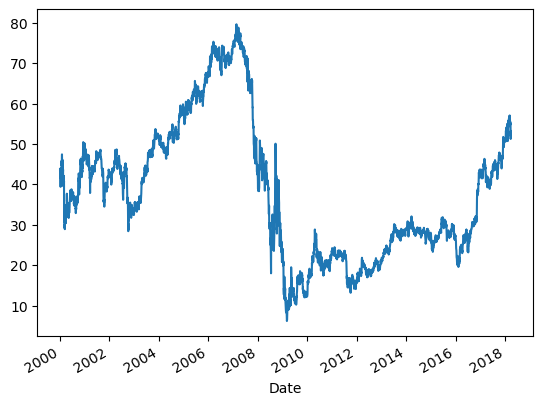

In [44]:
zion["Adj. Close"].plot()

In [45]:
# Make sure "Date" is sorted.
# From this link https://www.pythonforbeginners.com/basics/check-if-a-column-is-sorted-in-a-pandas-dataframe#:~:text=To%20check%20if%20a%20column%20in%20a%20dataframe%20is%20sorted,it%20is%20set%20to%20False.
zion.index.is_monotonic

True

## 2.3) Data wrangling

#### Check missing values

In [46]:
zion.isna().sum()

Open           0
High           0
Low            0
Close          0
Volume         0
Ex-Dividend    0
Split Ratio    0
Adj. Open      0
Adj. High      0
Adj. Low       0
Adj. Close     0
Adj. Volume    0
dtype: int64

#### Calculate returns
- There are two ways to calculate returns: simple and log returns.
- We will use the later. This is preferred: if prices are log-normally distributed then log returns are normally distributed.

In [47]:
# If we have not calculated return, then calculate return here
# Calculate log return
zion["log_rtn"] = np.log(zion["Adj. Close"]/zion["Adj. Close"].shift(1))
zion.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_rtn
Date,,,,,,,,,,,,,
2000-01-03,59.03,59.12,53.44,55.50,1199600.0,0.0,1.0,46.614284,46.685355,42.200023,43.826745,1199600.0,NaN
2000-01-04,54.63,55.00,52.50,52.81,816100.0,0.0,1.0,43.139731,43.431910,41.457732,41.702530,816100.0,-0.049682
2000-01-05,52.75,53.25,51.06,53.06,1124700.0,0.0,1.0,41.655150,42.049985,40.320606,41.899948,1124700.0,0.004723
2000-01-06,52.75,54.94,52.38,53.50,1112100.0,0.0,1.0,41.655150,43.384529,41.362971,42.247403,1112100.0,0.008258
2000-01-07,53.75,54.25,53.31,53.63,782000.0,0.0,1.0,42.444821,42.839656,42.097366,42.350060,782000.0,0.002427


In [48]:
zion.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_rtn
Date,,,,,,,,,,,,,
2018-03-21,54.94,55.78,54.39,55.10,1992966.0,0.0,1.0,54.94,55.78,54.39,55.10,1992966.0,0.005460
2018-03-22,54.53,54.70,52.97,53.07,2578239.0,0.0,1.0,54.53,54.70,52.97,53.07,2578239.0,-0.037538
2018-03-23,53.22,53.55,51.17,51.23,3378671.0,0.0,1.0,53.22,53.55,51.17,51.23,3378671.0,-0.035286
2018-03-26,52.20,53.41,51.90,53.24,2357767.0,0.0,1.0,52.20,53.41,51.90,53.24,2357767.0,0.038485
2018-03-27,53.25,53.71,51.62,52.02,2214940.0,0.0,1.0,53.25,53.71,51.62,52.02,2214940.0,-0.023182


<AxesSubplot:xlabel='Date'>

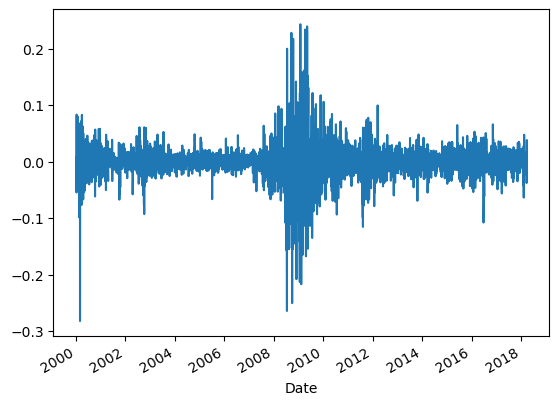

In [49]:
zion["log_rtn"].plot()

- Once the we have DatetimeIndex we can subset the dataset really easy. See https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/subset-time-series-data-python/ 

In [51]:
zion.index[0].year

2000

<AxesSubplot:xlabel='Date'>

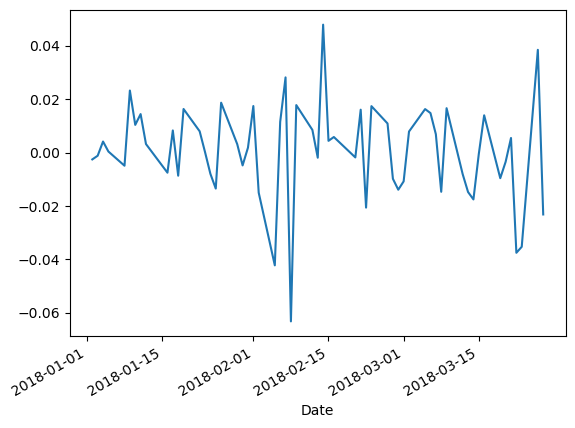

In [52]:
zion[zion.index.year == 2018]["log_rtn"].plot()

<AxesSubplot:xlabel='Date'>

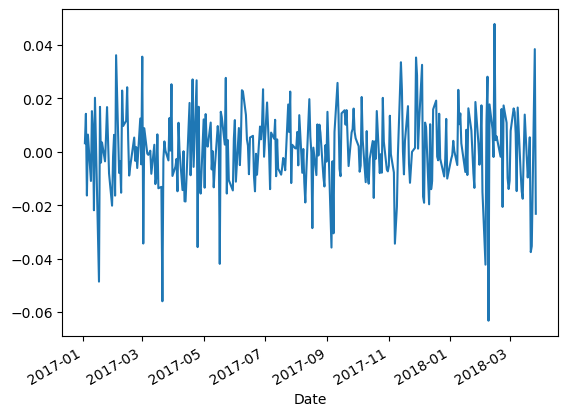

In [56]:
zion.loc["2017":"2018"]["log_rtn"].plot()

Before we do further calculation in the dataset. Just ouput summary stats here so that in the future we can check if we still have the same dataset.

In [59]:
zion.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,4586.0,4.247692e+01,2.022398e+01,6.380000,25.012500,4.150000e+01,5.693750e+01,8.827000e+01
High,4586.0,4.301802e+01,2.031932e+01,7.410000,25.422500,4.235500e+01,5.749500e+01,1.075900e+02
Low,4586.0,4.191482e+01,2.014377e+01,5.900000,24.617500,4.075500e+01,5.631000e+01,8.781000e+01
Close,4586.0,4.247297e+01,2.023162e+01,6.480000,25.150000,4.155000e+01,5.698000e+01,8.828000e+01
Volume,4586.0,2.218395e+06,2.280179e+06,66000.000000,544300.000000,1.655200e+06,3.035258e+06,2.633310e+07
Ex-Dividend,4586.0,2.673354e-03,2.823574e-02,0.000000,0.000000,0.000000e+00,0.000000e+00,4.300000e-01
Split Ratio,4586.0,1.000000e+00,0.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
Adj. Open,4586.0,3.815980e+01,1.705589e+01,6.109201,24.296965,3.555373e+01,4.822746e+01,7.958553e+01
Adj. High,4586.0,3.865011e+01,1.712845e+01,7.095483,24.743015,3.619438e+01,4.864645e+01,1.019509e+02
Adj. Low,4586.0,3.765131e+01,1.700249e+01,5.649575,23.827051,3.489470e+01,4.759229e+01,7.917079e+01


#### Check for outliers
- See book "Python for Finance", page 78

In [23]:
# Create new dataframe that have only return
df = zion[["log_rtn"]].copy()
df.head()

,log_rtn
Date,
2000-01-03,NaN
2000-01-04,-0.049682
2000-01-05,0.004723
2000-01-06,0.008258
2000-01-07,0.002427


In [24]:
# Calculate the rolling mean and standard deviation
df_rolling = df[["log_rtn"]].rolling(window=21) \
                        .agg(["mean", "std"])
df_rolling.columns = df_rolling.columns.droplevel() # Drop multi-level index
df_rolling.head()

,mean,std
Date,,
2000-01-03,NaN,NaN
2000-01-04,NaN,NaN
2000-01-05,NaN,NaN
2000-01-06,NaN,NaN
2000-01-07,NaN,NaN


In [25]:
# Join the rolling data back to the initial DataFrame
df = df.join(df_rolling)
df.head()

,log_rtn,mean,std
Date,,,
2000-01-03,NaN,NaN,NaN
2000-01-04,-0.049682,NaN,NaN
2000-01-05,0.004723,NaN,NaN
2000-01-06,0.008258,NaN,NaN
2000-01-07,0.002427,NaN,NaN


In [26]:
# Calculate the upper and lower thresholds
N_SIGMAS = 3
df["upper"] = df["mean"] + N_SIGMAS * df["std"]
df["lower"] = df["mean"] - N_SIGMAS * df["std"]

# Identify the outliers using the previously calculated thresholds
df["outlier"] = (
    (df["log_rtn"] > df["upper"]) | (df["log_rtn"] < df["lower"])
)

In [33]:
# Figure parameters
# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 6]}) 
# Thanh changed from original [8 (width), 20 (height)] (not remember of what graph)
# for ACF and PACF in case need to see clearly, Thanh changed to [12, 20]
# for Decomposition (since it has 4 graphs) to see clearly, Thanh also used [12, 20]
# For single graph such as outlier Thanh used [12, 6]

<Figure size 1200x2000 with 0 Axes>

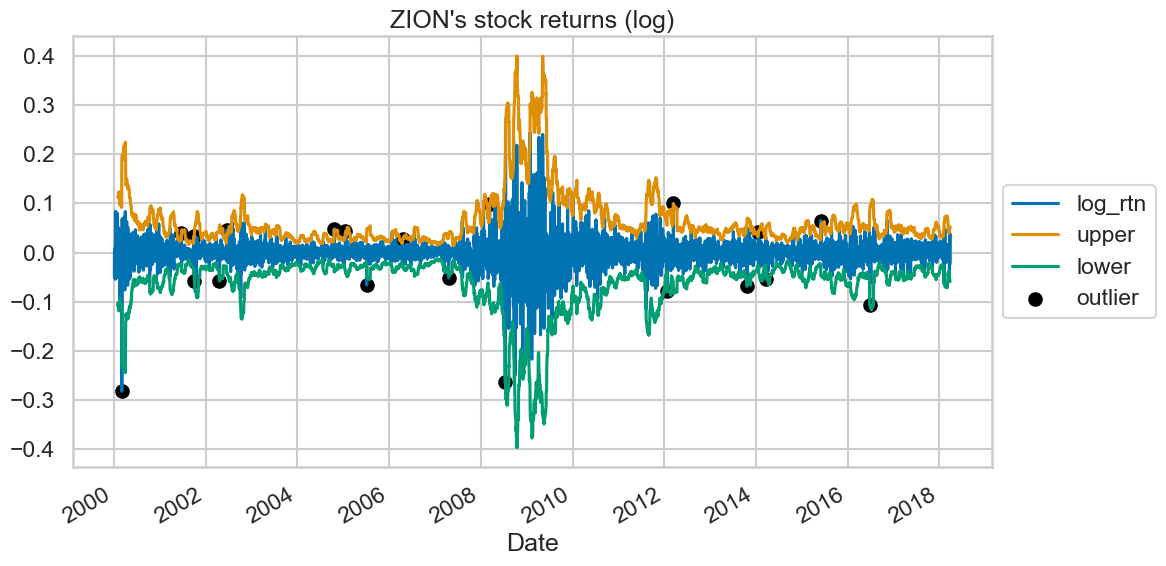

In [34]:
# Plot the returns together with the thresholds and mark the outliers
plt.figure(figsize=(12, 20))

fig, ax = plt.subplots()

df[["log_rtn", "upper", "lower"]].plot(ax=ax)
ax.scatter(df.loc[df["outlier"]].index, 
           df.loc[df["outlier"], "log_rtn"], 
           color="black", label="outlier")
ax.set_title("ZION's stock returns (log)")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5)) # Put legends outside of the graph
#sns.despine()
plt.tight_layout() 

# plt.savefig("images/figure_4_1", dpi=200)

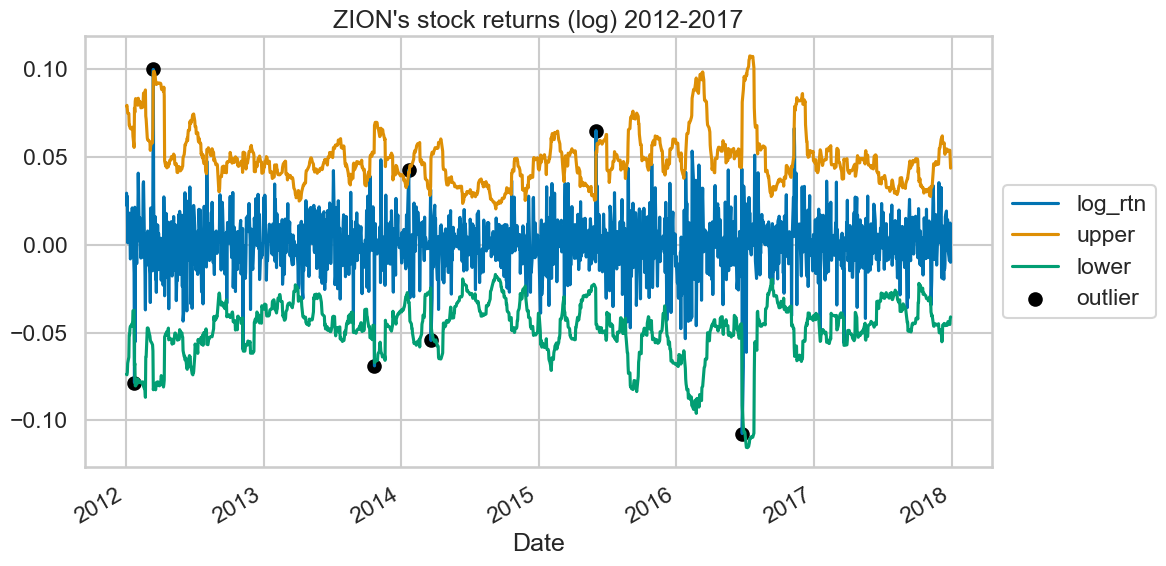

In [35]:
# Plot the 6 three years 2012-2017
fig, ax = plt.subplots()

df.loc["2012":"2017"][["log_rtn", "upper", "lower"]].plot(ax=ax)
ax.scatter(df.loc["2012":"2017"].loc[df["outlier"]].index, 
           df.loc["2012":"2017"].loc[df["outlier"], "log_rtn"], 
           color="black", label="outlier")
ax.set_title("ZION's stock returns (log) 2012-2017")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5)) # Put legends outside of the graph
#sns.despine()
plt.tight_layout() 

We have only 7 outliers and they are just in the border. Just, we don't do anything with them at this time.

# Step3 EDA

## 3.1) Detecting patterns using the Hurst exponent
Deterimine if stock is trending, mean-reverting or random walk.
H < 0.5 - a series is mean-reverting (closer to zero the stronger)
H = 0 - geometric random walk
H > 0.5 - a series is trending (closer to 1 the stronger)

In [77]:
# Define a function calculating the Hurst exponent
def get_hurst_exponent(ts, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    
    lags = range(2, max_lag)

    # standard deviations of the lagged differences
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    hurst_exp = np.polyfit(np.log(lags), np.log(tau), 1)[0]

    return hurst_exp

In [79]:
for lag in [20, 100, 250, 500, 1000]:
    hurst_exp = get_hurst_exponent(zion["Adj. Close"].values, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

Hurst exponent with 20 lags: 0.4472
Hurst exponent with 100 lags: 0.4816
Hurst exponent with 250 lags: 0.5112
Hurst exponent with 500 lags: 0.5605
Hurst exponent with 1000 lags: 0.5662


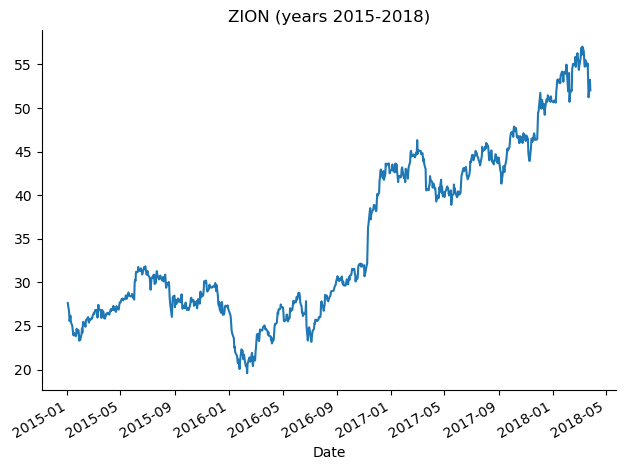

In [84]:
# Narrow down the data to the years from 2015 to end (2018) and calculate the exponents one more time
zion.loc["2015":, "Adj. Close"].plot(title="ZION (years 2015-2018)")
sns.despine() # Not sure what this does
plt.tight_layout()
# plt.savefig("images/figure_4_10", dpi=200);

In [85]:
shorter_series = zion.loc["2015":, "Adj. Close"].values
for lag in [20, 100, 250, 500]:
    hurst_exp = get_hurst_exponent(shorter_series, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

Hurst exponent with 20 lags: 0.4748
Hurst exponent with 100 lags: 0.5084
Hurst exponent with 250 lags: 0.5012
Hurst exponent with 500 lags: 0.3478


## 3.2) Investigating stylized facts of asset returns

In [89]:
# We might already have return calculated
# Create df with return
df = zion[["Adj. Close"]].rename(
    columns={"Adj. Close": "adj_close"}
)
df["log_rtn"] = np.log(df["adj_close"]/df["adj_close"].shift(1))
df = df[["adj_close", "log_rtn"]].dropna()
df

,adj_close,log_rtn
Date,,
2000-01-04,41.702530,-0.049682
2000-01-05,41.899948,0.004723
2000-01-06,42.247403,0.008258
2000-01-07,42.350060,0.002427
2000-01-10,41.584079,-0.018252
...,...,...
2018-03-21,55.100000,0.005460
2018-03-22,53.070000,-0.037538
2018-03-23,51.230000,-0.035286


#### Fact 1 - Non-Gaussian distribution of returns

In [90]:
# Calculate the Normal PDF using the mean and standard deviation of the observed returns
r_range = np.linspace(min(df["log_rtn"]), 
                      max(df["log_rtn"]), 
                      num=1000)
mu = df["log_rtn"].mean()
sigma = df["log_rtn"].std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)   

C:\Users\nguye\AppData\Local\Temp\ipykernel_7584\1472630299.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.log_rtn, kde=False,


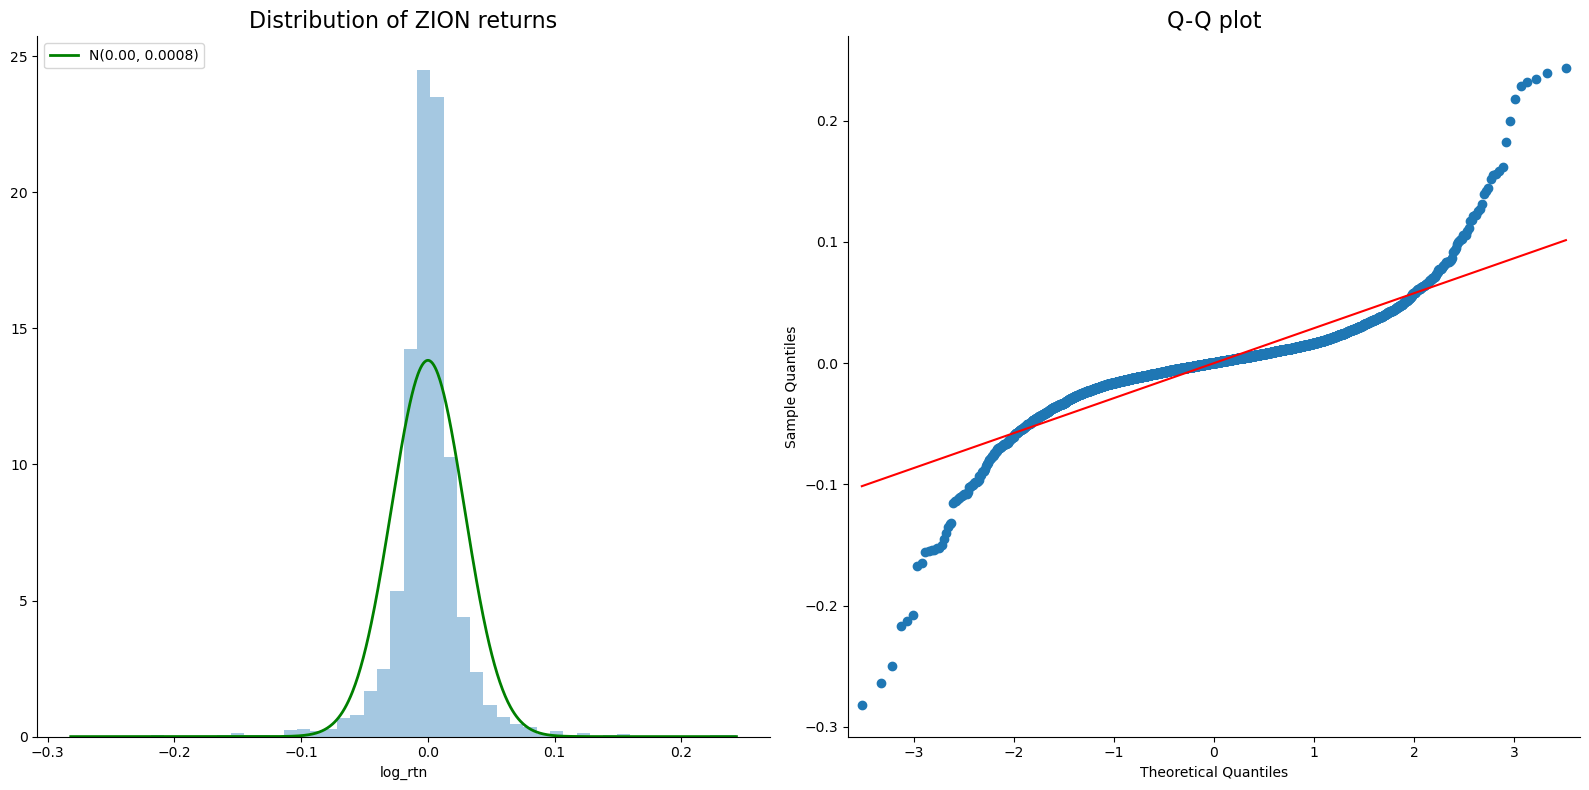

In [92]:
# Plot the histogram and the Q-Q Plot
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# histogram
sns.distplot(df.log_rtn, kde=False, 
             norm_hist=True, ax=ax[0])
# kde=False doesnot use Gaussian kernel density estimate
# norm_hist=True plot shows density instead of count

ax[0].set_title("Distribution of ZION returns", 
                fontsize=16)                                                    
ax[0].plot(r_range, norm_pdf, "g", lw=2, 
           label=f"N({mu:.2f}, {sigma**2:.4f})")
ax[0].legend(loc="upper left");

# Q-Q plot
qq = sm.qqplot(df.log_rtn.values, line="s", ax=ax[1])
ax[1].set_title("Q-Q plot", fontsize = 16)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_11", dpi=200);

- Negative skewness: one can see more big negative returns than big positive returns.
- Positive kurtosis: fat tails and peak over PDF of normal distribution.
- If log-rtn is normal, most of points should be in the red line.

In [94]:
# Print the summary statistics of the log returns
jb_test = scs.jarque_bera(df["log_rtn"].values) # Test of normality

print("---------- Descriptive Statistics ----------")
print("Range of dates:", min(df.index.date), "-", max(df.index.date))
print("Number of observations:", df.shape[0])
print(f"Mean: {df.log_rtn.mean():.8f}")
print(f"Median: {df.log_rtn.median():.4f}")
print(f"Min: {df.log_rtn.min():.4f}")
print(f"Max: {df.log_rtn.max():.4f}")
print(f"Standard Deviation: {df.log_rtn.std():.4f}")
print(f"Skewness: {df.log_rtn.skew():.4f}")
print(f"Kurtosis: {df.log_rtn.kurtosis():.4f}") 
print(f"Jarque-Bera statistic: {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}")


---------- Descriptive Statistics ----------
Range of dates: 2000-01-04 - 2018-03-27
Number of observations: 4585
Mean: 0.00003738
Median: 0.0003
Min: -0.2817
Max: 0.2434
Standard Deviation: 0.0289
Skewness: -0.1397
Kurtosis: 17.3464
Jarque-Bera statistic: 57365.12 with p-value: 0.00


#### Fact 2 - Volatility Clustering
This is when large price changes are followed by large changes (period of high volatility); and period of low volatility

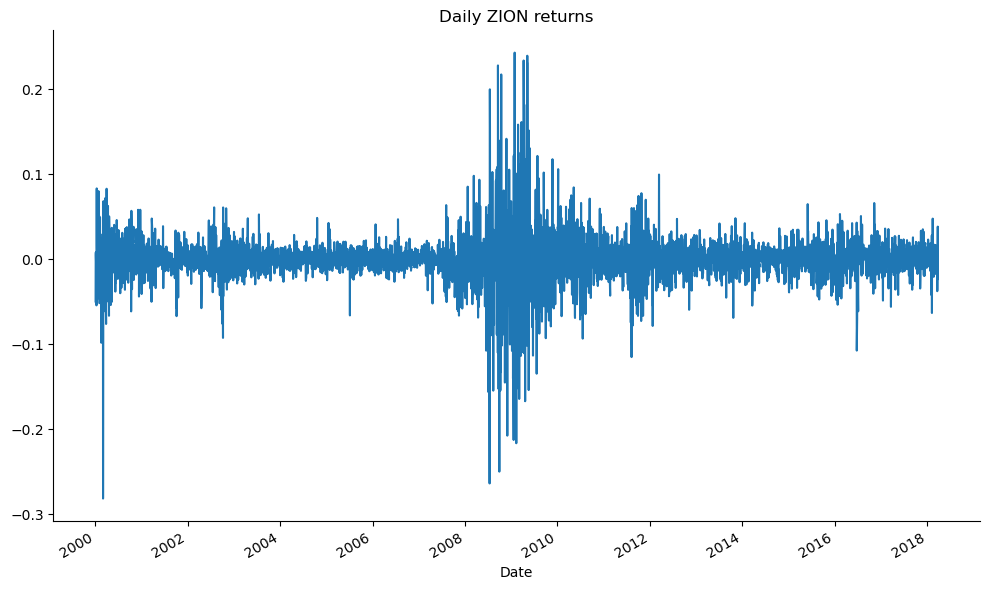

In [97]:
(
    df["log_rtn"]
    .plot(title="Daily ZION returns", figsize=(10, 6))
)
sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_12", dpi=200);

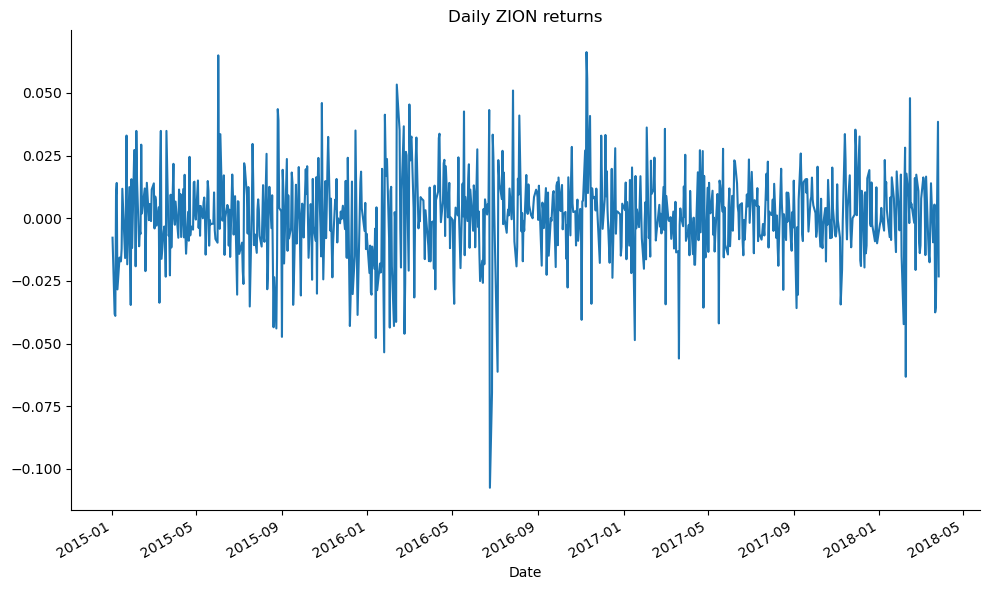

In [98]:
(
    df.loc["2015":]["log_rtn"]
    .plot(title="Daily ZION returns", figsize=(10, 6))
)
sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_12", dpi=200);

#### Fact 3 - Absence of autocorrelation in returns

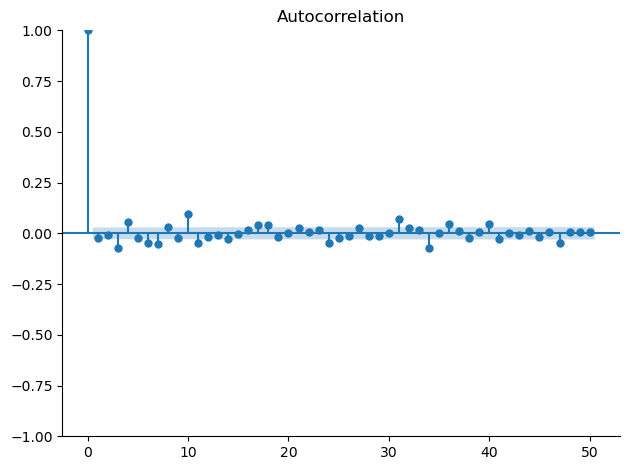

In [99]:
# Define the parameters for creating the autocorrelation plots
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05
# Create ACF plot of log returns
acf = smt.graphics.plot_acf(df["log_rtn"], 
                            lags=N_LAGS, 
                            alpha=SIGNIFICANCE_LEVEL)
sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_13", dpi=200);

We see there are some significant autocorrelation at lag 10. For ML approach, let include up to lag 14.

#### Fact 4 - Small and decreasing autocorrelation in squared/absolute returns
Instead of using rtns, if we use squared or absolute of returns, then we will observed autocorrelation. This is consistent with fact 2 (volatility clustering). 

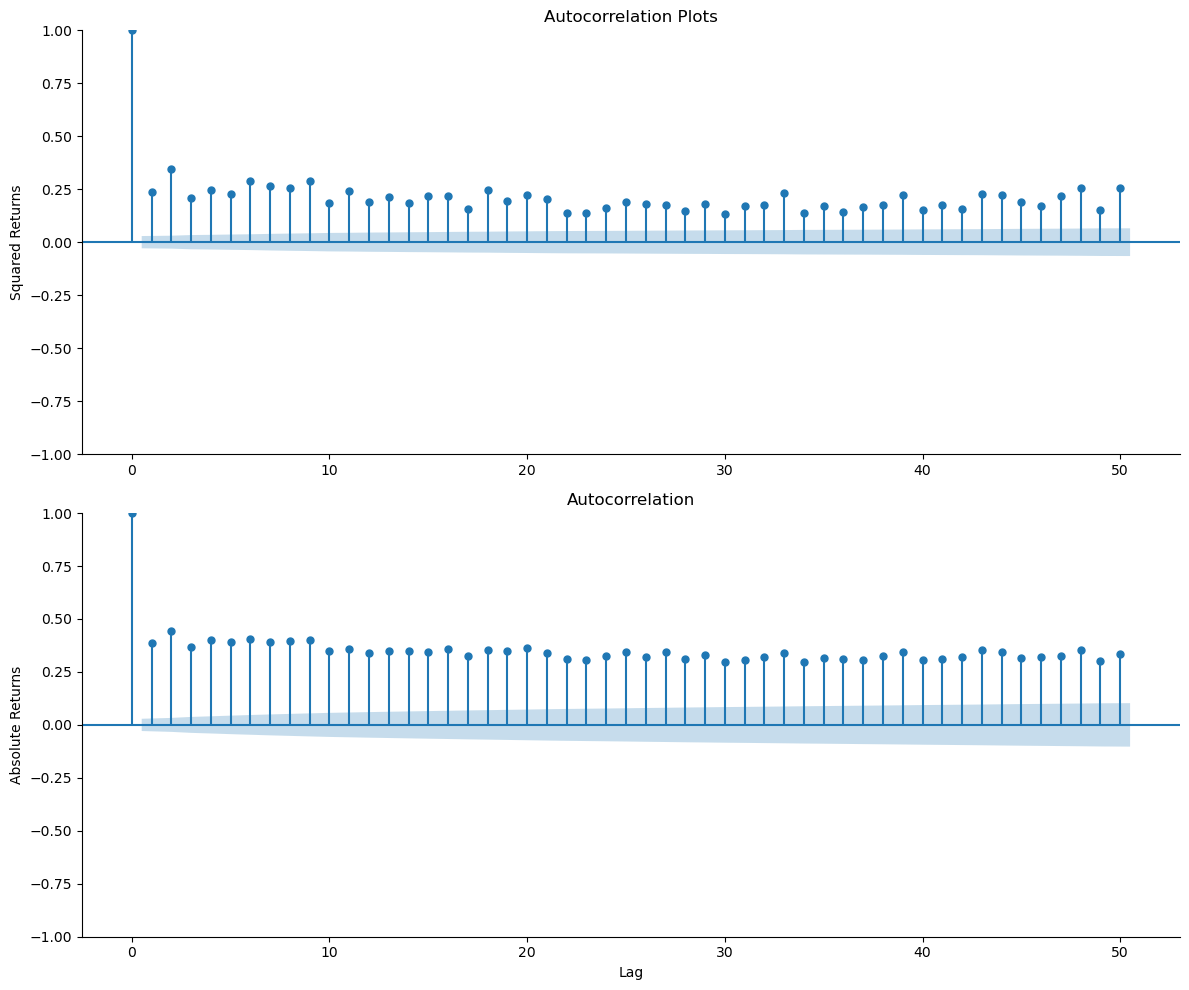

In [100]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

smt.graphics.plot_acf(df["log_rtn"]**2, lags=N_LAGS, 
                      alpha=SIGNIFICANCE_LEVEL, ax=ax[0])
ax[0].set(title="Autocorrelation Plots",
          ylabel="Squared Returns")

smt.graphics.plot_acf(np.abs(df["log_rtn"]), lags=N_LAGS, 
                      alpha=SIGNIFICANCE_LEVEL, ax=ax[1])
ax[1].set(ylabel="Absolute Returns",
          xlabel="Lag")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_14", dpi=200);

We don't see strong evidence that the autocorrelation is decreasing.

##### Fact 5 - Leverage effect
Leverage effect refers to the fact that most measures of volatility negatively correlated with rtn.

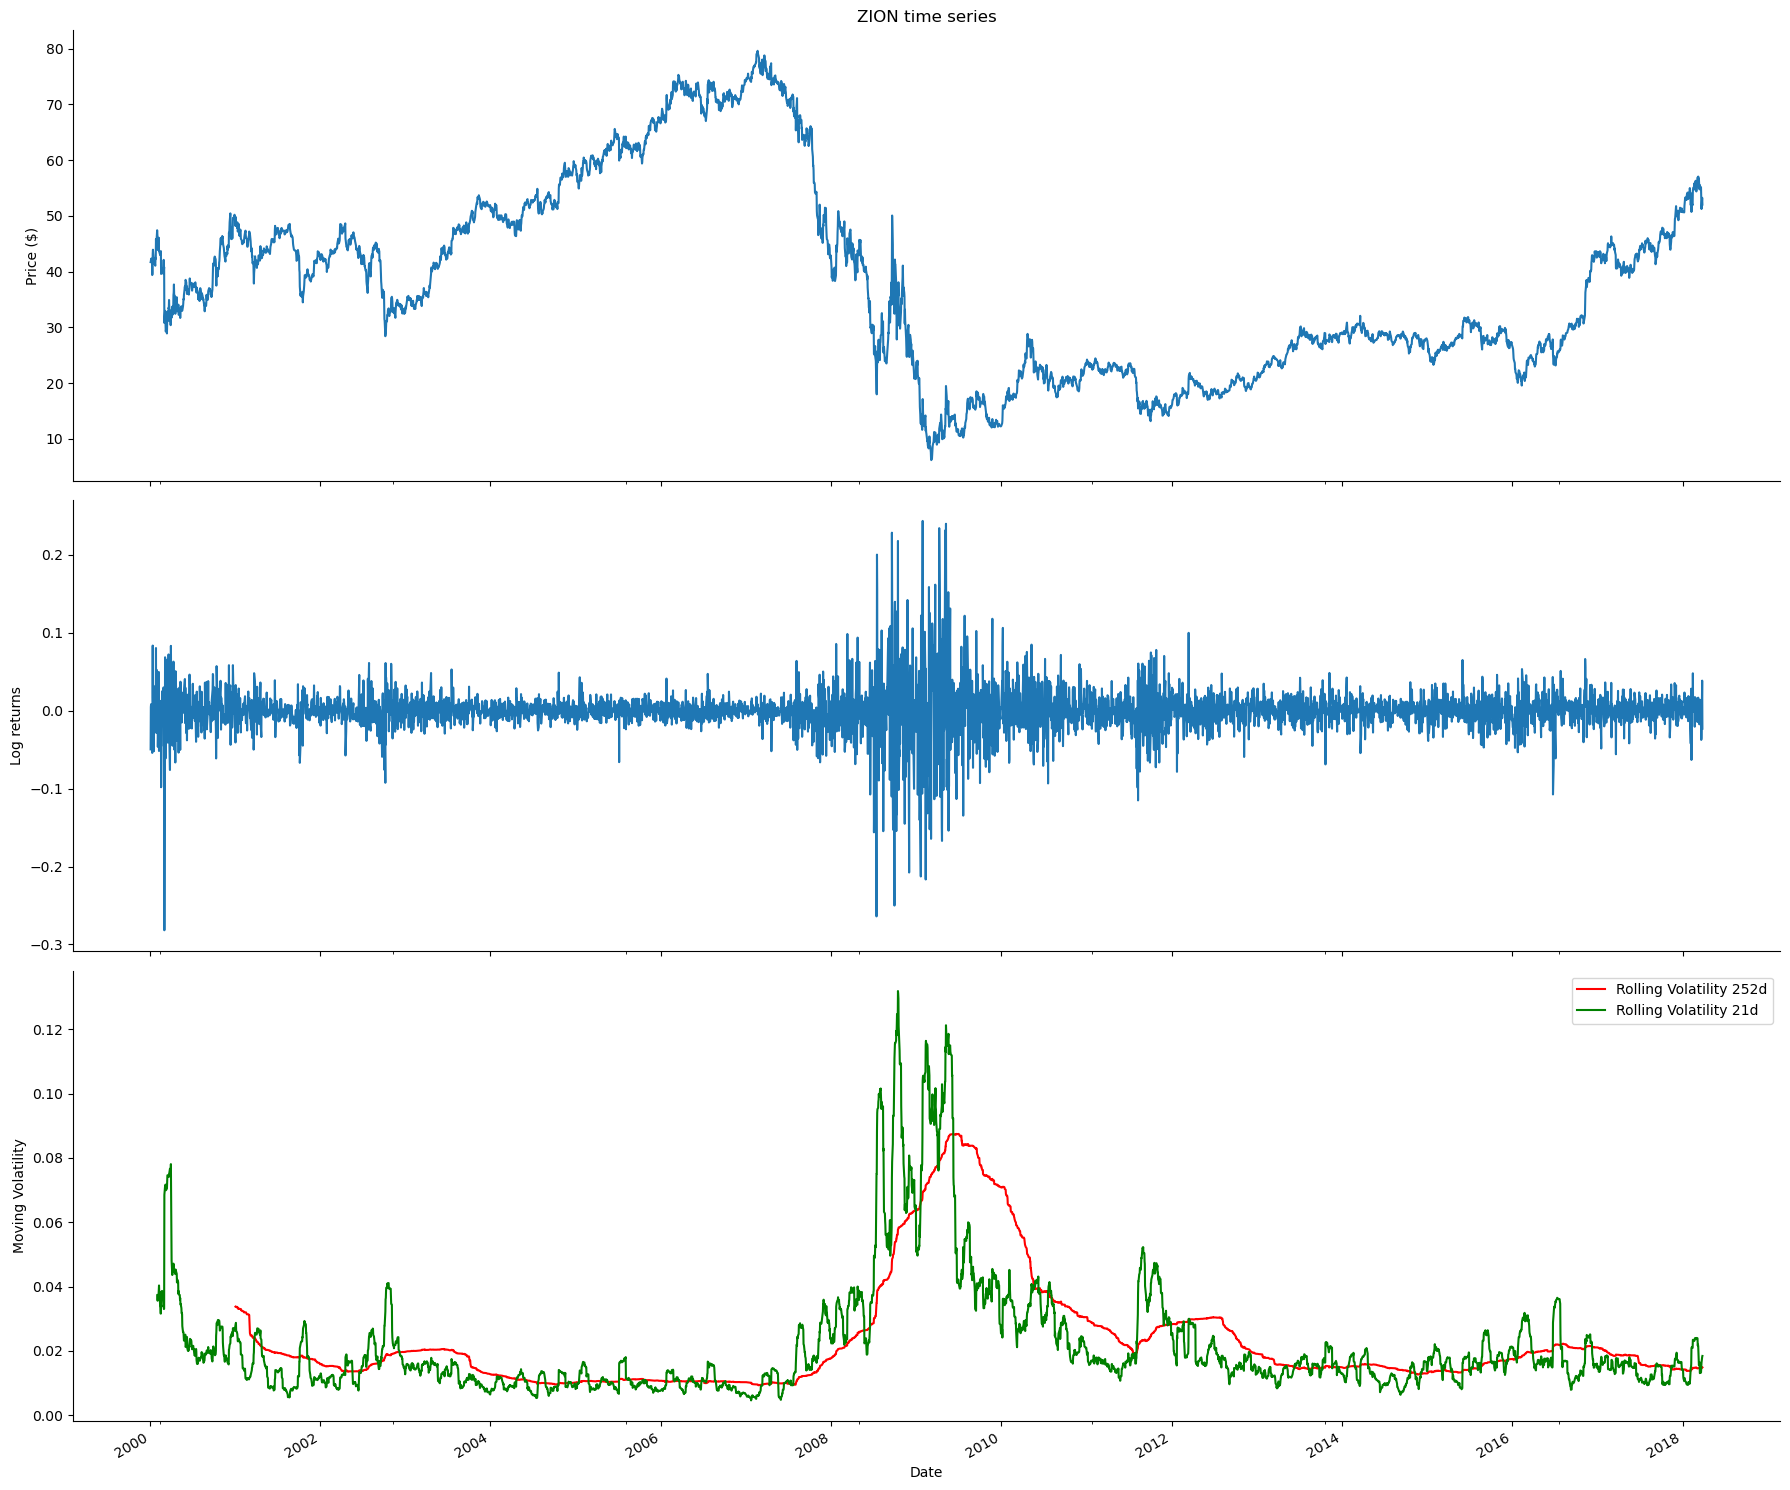

In [101]:
# Calculate volatility measures as moving standard deviations
df["rolling_std_252"] = df[["log_rtn"]].rolling(window=252).std()
df["rolling_std_21"] = df[["log_rtn"]].rolling(window=21).std()

# Plot all the series
fig, ax = plt.subplots(3, 1, figsize=(18, 15), 
                       sharex=True)

df["adj_close"].plot(ax=ax[0])
ax[0].set(title="ZION time series",
          ylabel="Price ($)")

df["log_rtn"].plot(ax=ax[1])
ax[1].set(ylabel="Log returns")

df["rolling_std_252"].plot(ax=ax[2], color="r", 
                           label="Rolling Volatility 252d")
df["rolling_std_21"].plot(ax=ax[2], color="g", 
                           label="Rolling Volatility 21d")
ax[2].set(ylabel="Moving Volatility",
          xlabel="Date")
ax[2].legend()

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_15", dpi=200);

We can see in the graph when price goes up, volatility goes down and vice versa. Should this be just a mathematical relationship (we calculate rtn so prices are in denominators?

## 3.3) Decomposition
- The challenge here is how to specify the period of the seasonality in seasonal_decompose(). 
	- The number of trading days in weeks, months, years are different. 
- And further challenge, how do we specify seasonality (parameter S) in the ARIMA(P, D, Q, S)
- Google this (need to Google)

- For now use period=252

In [108]:
zion.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_rtn
Date,,,,,,,,,,,,,
2000-01-03,59.03,59.12,53.44,55.50,1199600.0,0.0,1.0,46.614284,46.685355,42.200023,43.826745,1199600.0,NaN
2000-01-04,54.63,55.00,52.50,52.81,816100.0,0.0,1.0,43.139731,43.431910,41.457732,41.702530,816100.0,-0.049682
2000-01-05,52.75,53.25,51.06,53.06,1124700.0,0.0,1.0,41.655150,42.049985,40.320606,41.899948,1124700.0,0.004723
2000-01-06,52.75,54.94,52.38,53.50,1112100.0,0.0,1.0,41.655150,43.384529,41.362971,42.247403,1112100.0,0.008258
2000-01-07,53.75,54.25,53.31,53.63,782000.0,0.0,1.0,42.444821,42.839656,42.097366,42.350060,782000.0,0.002427


In [38]:
# Figure parameters
# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 20]}) 
# Thanh changed from original [8 (width), 20 (height)] (not remember of what graph)
# for ACF and PACF in case need to see clearly, Thanh changed to [12, 20]
# for Decomposition (since it has 4 graphs) to see clearly, Thanh also used [12, 20]
# For single graph such as outlier Thanh used [12, 6]

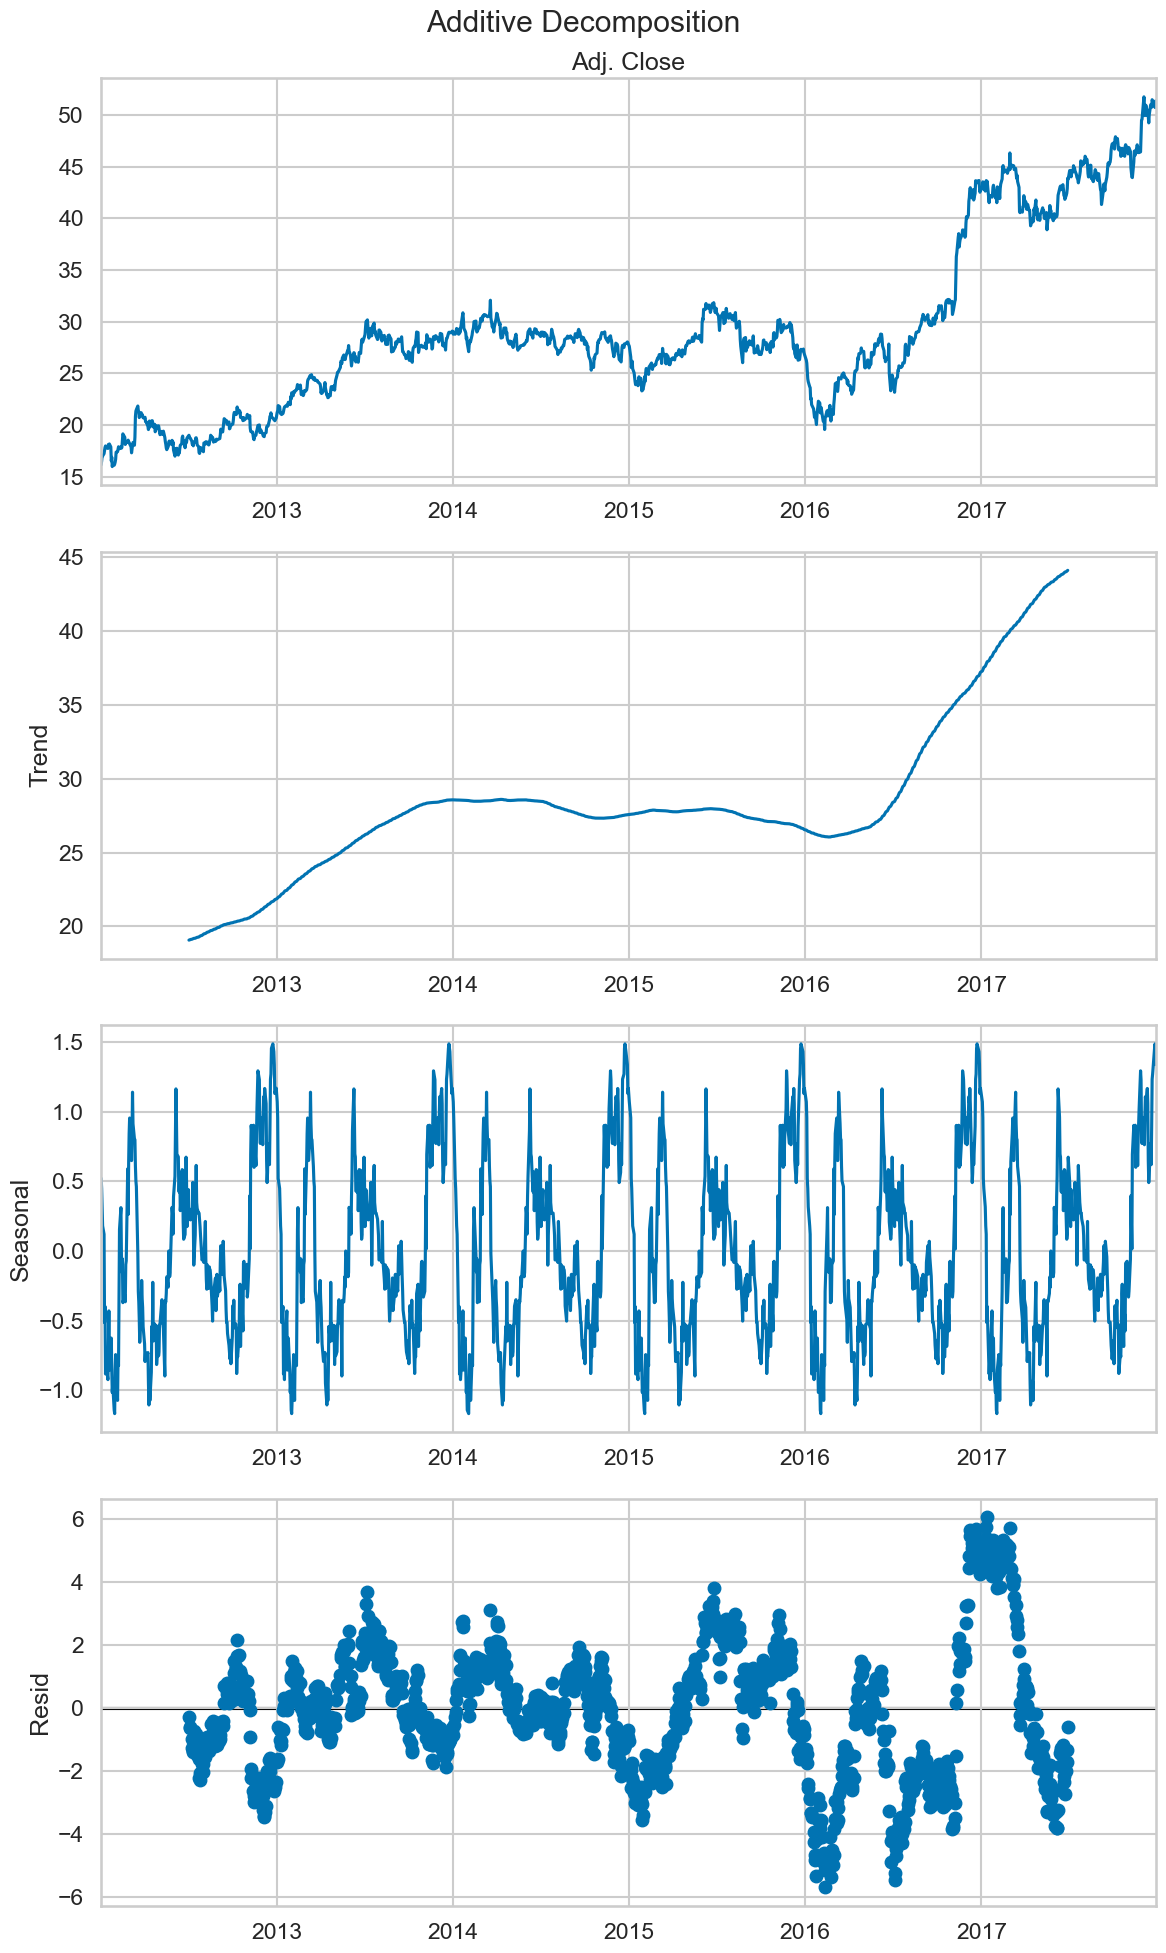

In [39]:
# This is for "Adj. Close" and 2012-17
# Carry out seasonal decomposition using the additive model
decomposition_results = seasonal_decompose(zion.loc["2012":"2017", "Adj. Close"], model="additive", period=252)
decomposition_results.plot().suptitle("Additive Decomposition")

plt.tight_layout()
# plt.savefig("images/figure_6_4", dpi=200)

- For stock prices, the residuals here are not white noise. I think because we force seasonal_decompose() to extract seasonal component. So the residuals turn out to have some serialcorrelation.
- Need to read about this function seasonal_decompose().

###### The above looks at closing prices.
# Let look at seasonality of returns and 2012-17

decomposition_results = seasonal_decompose(zion.loc["2012":"2017", "log_rtn"], model="additive", period=252)
decomposition_results.plot().suptitle("Additive Decomposition")

# sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_4", dpi=200)

###### This one look at closing price again, but without specifying period

decomposition_results = seasonal_decompose(zion.loc["2015":"2017", "Adj. Close"], model="additive")
decomposition_results.plot().suptitle("Additive Decomposition")

# sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_4", dpi=200)

## 3.4) Testing for stationarity
- We will use both adfuller() and kpss() to test for stationarity

In [42]:
# Define a function for running the ADF test
# Code taken from book "Python for Finance Cookbook"
# Number of lags is auto-determined by AIC 

def adf_test(x):
    """
    Function for performing the Augmented Dickey-Fuller test for stationarity
    
    Null Hypothesis: time series is not stationary
    Alternate Hypothesis: time series is stationary

    Parameters
    ----------
    x : pd.Series / np.array
        The time series to be checked for stationarity
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the ADF test's results
    """
    
    indices = ["Test Statistic", "p-value",
               "# of Lags Used", "# of Observations Used"]
    
    adf_test = adfuller(x, autolag="AIC")
    results = pd.Series(adf_test[0:4], index=indices)
    
    for key, value in adf_test[4].items():
        results[f"Critical Value ({key})"] = value

    return results

In [9]:
adf_test(zion["log_rtn"].dropna())

Test Statistic           -1.102751e+01
p-value                   5.778224e-20
# of Lags Used            3.100000e+01
# of Observations Used    4.553000e+03
Critical Value (1%)      -3.431787e+00
Critical Value (5%)      -2.862175e+00
Critical Value (10%)     -2.567108e+00
dtype: float64

In [43]:
# Check if the results will be different for 2012-17
adf_test(zion.loc["2012":"2017", "log_rtn"])

Test Statistic             -27.581015
p-value                      0.000000
# of Lags Used               1.000000
# of Observations Used    1506.000000
Critical Value (1%)         -3.434700
Critical Value (5%)         -2.863461
Critical Value (10%)        -2.567793
dtype: float64

In [44]:
# Define a function for running the KPSS test
# Code taken from book "Python for Finance Cookbook"
def kpss_test(x, h0_type="c"):
    """
    Function for performing the Kwiatkowski-Phillips-Schmidt-Shin test for stationarity

    Null Hypothesis: time series is stationary
    Alternate Hypothesis: time series is not stationary

    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    h0_type: str{"c", "ct"}
        Indicates the null hypothesis of the KPSS test:
            * "c": The data is stationary around a constant(default)
            * "ct": The data is stationary around a trend
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the KPSS test's results
    """
    
    indices = ["Test Statistic", "p-value", "# of Lags"]

    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    
    for key, value in kpss_test[3].items():
        results[f"Critical Value ({key})"] = value

    return results

In [12]:
kpss_test(zion["log_rtn"].dropna())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Test Statistic            0.119192
p-value                   0.100000
# of Lags                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

In [45]:
# For 2012-17
kpss_test(zion.loc["2012":"2017", "log_rtn"])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Test Statistic           0.084624
p-value                  0.100000
# of Lags                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

## 3.7) ACF and PACF

In [17]:
# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 20]}) # Thanh changed from 8 to 20 for ACF and PACF to see clearly.

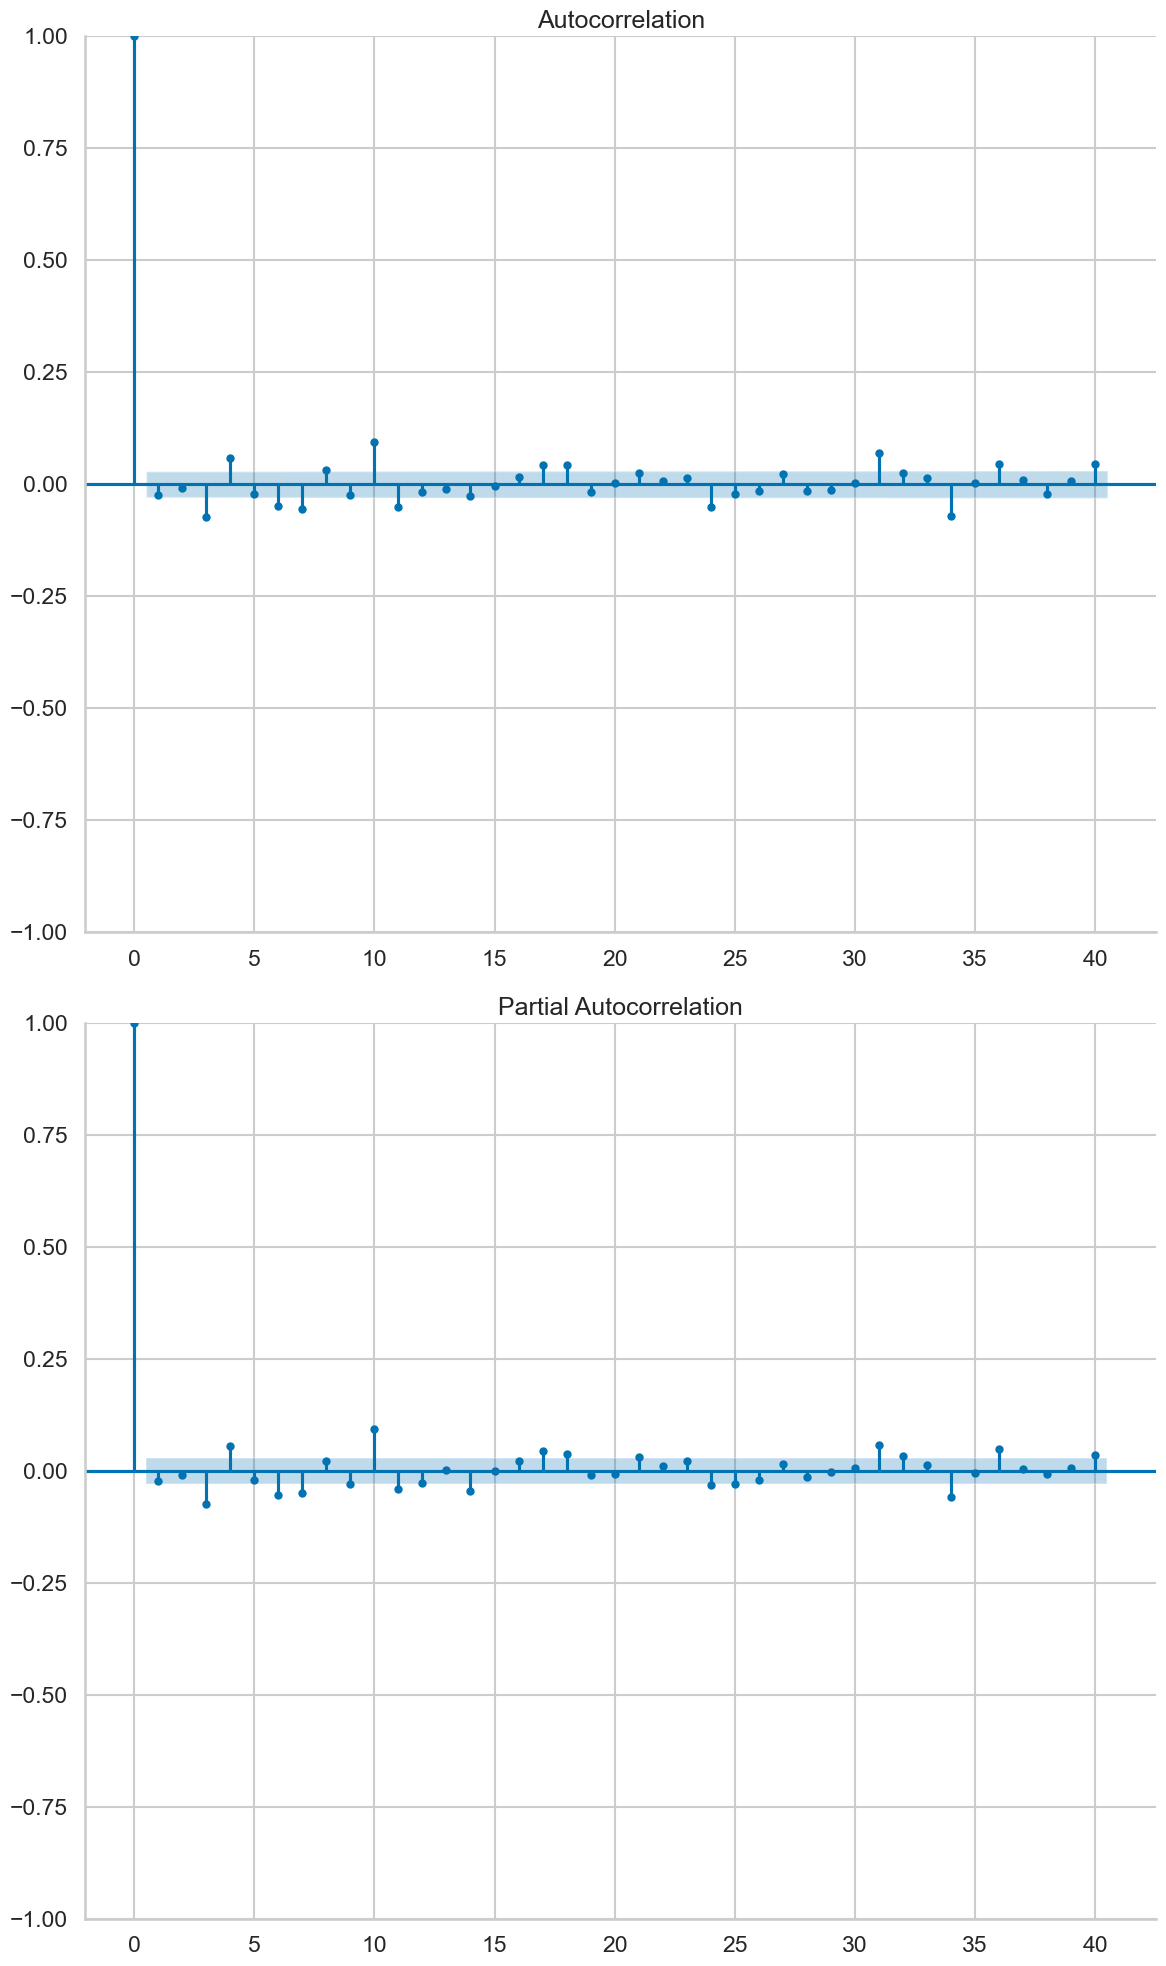

In [48]:
# Generate the ACF/PACF plots
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2, 1)
plot_acf(zion["log_rtn"].dropna(), ax=ax[0], lags=N_LAGS, 
         alpha=SIGNIFICANCE_LEVEL)
plot_pacf(zion["log_rtn"].dropna(), ax=ax[1], lags=N_LAGS, 
          alpha=SIGNIFICANCE_LEVEL)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_7", dpi=200)

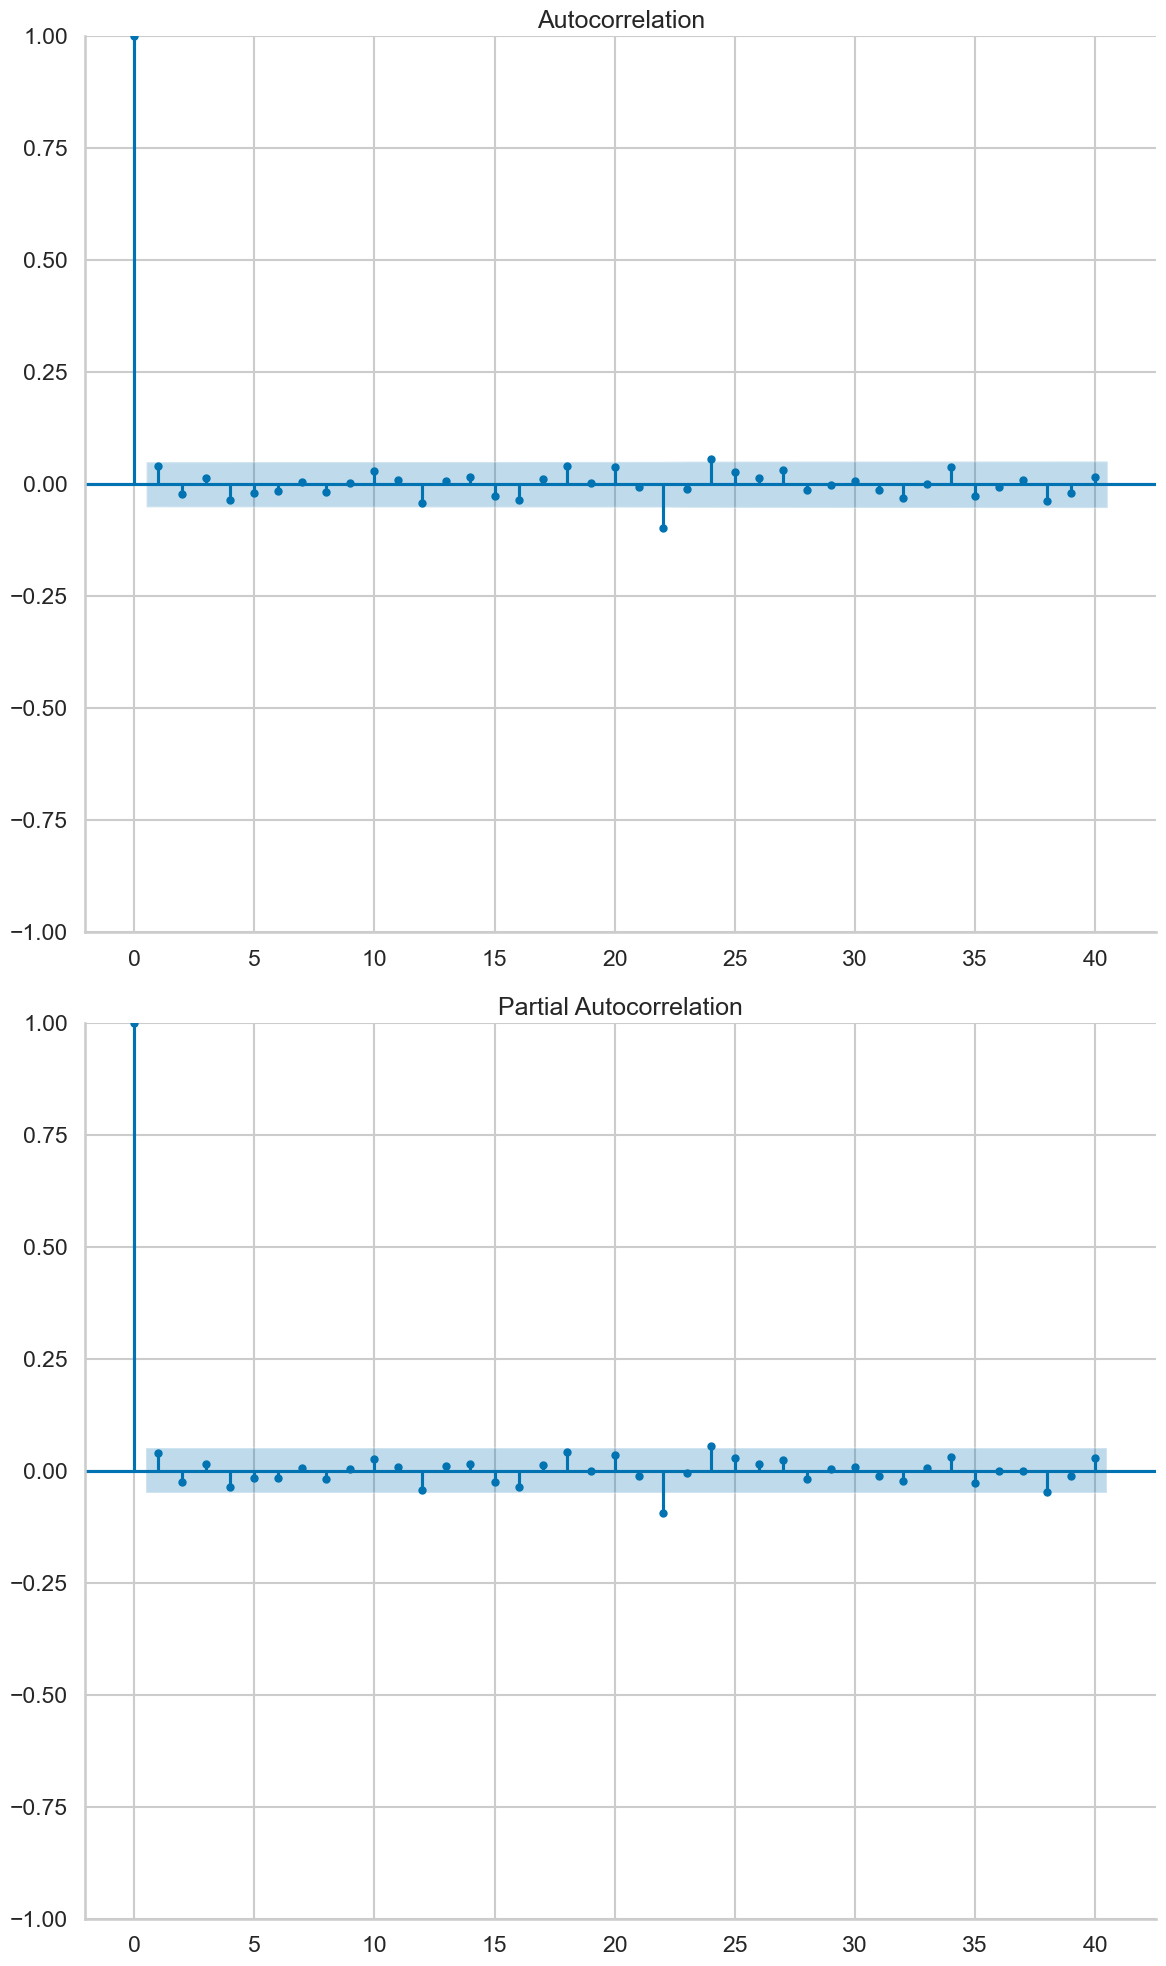

In [49]:
# Generate the ACF/PACF plots and for 2012-17
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2, 1)
plot_acf(zion.loc["2012":"2017", "log_rtn"].dropna(), ax=ax[0], lags=N_LAGS, 
         alpha=SIGNIFICANCE_LEVEL)
plot_pacf(zion.loc["2012":"2017", "log_rtn"].dropna(), ax=ax[1], lags=N_LAGS, 
          alpha=SIGNIFICANCE_LEVEL)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_7", dpi=200)

If we use all data (2000-2018), some random ACF and PACF are significant. If we use 2012-17 data, none of them are significant. Probably because, there are fewer observations. Anyway, we don't expect to see any correlation in stock returns.
ACF and PACF plots are almost the same. This is because stock returns are white noise (with drift).

## 3.6) Feature engineering
In this section we will create features to predict returns. The features will be used in ML algorythm as well as in ARIMAX models.
- rtn_lag1 to rtn_lag14 (reason for 14 is that we see some ACF significant around lag10).
- moving_average_50, moving_average_200 (common numbers are 14, 50, 200; but we already use lag until 14)
- relative_strength_index_50 (RSI), RSI_200
- volume_change ???
- Month of year (to account for any annual seasonality).

#### Create lag returns

In [7]:
zion.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_rtn
Date,,,,,,,,,,,,,
2000-01-03,59.03,59.12,53.44,55.50,1199600.0,0.0,1.0,46.614284,46.685355,42.200023,43.826745,1199600.0,NaN
2000-01-04,54.63,55.00,52.50,52.81,816100.0,0.0,1.0,43.139731,43.431910,41.457732,41.702530,816100.0,-0.049682
2000-01-05,52.75,53.25,51.06,53.06,1124700.0,0.0,1.0,41.655150,42.049985,40.320606,41.899948,1124700.0,0.004723
2000-01-06,52.75,54.94,52.38,53.50,1112100.0,0.0,1.0,41.655150,43.384529,41.362971,42.247403,1112100.0,0.008258
2000-01-07,53.75,54.25,53.31,53.63,782000.0,0.0,1.0,42.444821,42.839656,42.097366,42.350060,782000.0,0.002427


In [8]:
# Shifts
shifts = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# Create a dictionary of time-shifted data
many_shifts = {'log_rtn_lag_{}'.format(ii): zion["log_rtn"].shift(ii) for ii in shifts}

# Convert them into a dataframe
many_shifts = pd.DataFrame(many_shifts)

In [9]:
type(many_shifts)

pandas.core.frame.DataFrame

In [10]:
many_shifts.head()

,log_rtn_lag_0,log_rtn_lag_1,log_rtn_lag_2,log_rtn_lag_3,log_rtn_lag_4,log_rtn_lag_5,log_rtn_lag_6,log_rtn_lag_7,log_rtn_lag_8,log_rtn_lag_9,log_rtn_lag_10,log_rtn_lag_11,log_rtn_lag_12,log_rtn_lag_13,log_rtn_lag_14
Date,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,-0.049682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,0.004723,-0.049682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,0.008258,0.004723,-0.049682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,0.002427,0.008258,0.004723,-0.049682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Calculate moving average and relative strength index
We will calculate moving_average_50, moving_average_200, relative_strength_index_50 (RSI), RSI_200

In [12]:
zion['ma14'] = talib.SMA(zion['Adj. Close'].values, timeperiod=14)
zion['rsi14'] = talib.RSI(zion['Adj. Close'].values, timeperiod=14)
zion['ma50'] = talib.SMA(zion['Adj. Close'].values, timeperiod=50)
zion['rsi50'] = talib.RSI(zion['Adj. Close'].values, timeperiod=50)
zion['ma200'] = talib.SMA(zion['Adj. Close'].values, timeperiod=200)
zion['rsi200'] = talib.RSI(zion['Adj. Close'].values, timeperiod=200)

#### Calculate volume based features
We will calculate one day volumn change and 10-day moving average of one-day volumn changes

In [13]:
zion["vol_1d_change"] = np.log(zion["Adj. Volume"]/zion["Adj. Volume"].shift(1))
zion["vol_1d_change_ma10"] = talib.SMA(zion['vol_1d_change'].values, timeperiod=10)

#### Encode month of year
We will use sine and cosine to encode month of the year. This approach has a potential drawback especially when using tree-based algorythm. So we will not use these month features to train models. Once we have the best models (for ARIMA, Ridge(), KNN) we can try to include these month features to see if we can improve the performance by capturing some annual seasonality in the returns. 

In [15]:
zion.iloc[:5].index.month

Int64Index([1, 1, 1, 1, 1], dtype='int64', name='Date')

In [16]:
# Define functions used for creating the cyclical encoding
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

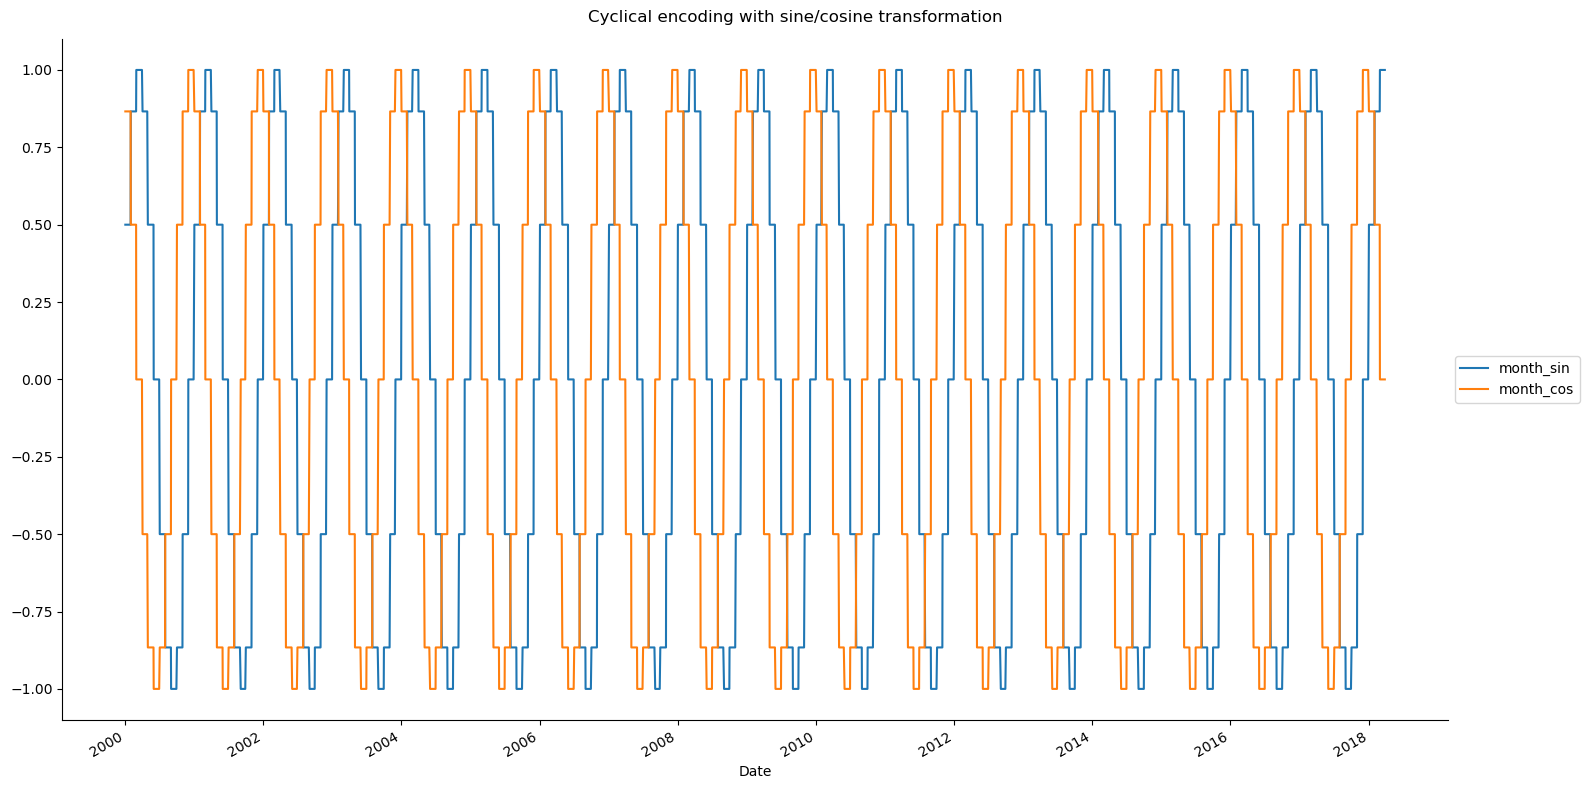

In [33]:
# Encode the month information using cyclical encoding
# Code from the book
X_2 = zion[['Open', 'Close']].copy() # If you choose only one column, you will get Series instead of DataFrame
                                     # And your index will no longer be DatetimeIndex
X_2["month"] = X_2.index.month

X_2["month_sin"] = sin_transformer(12).fit_transform(X_2)["month"]
X_2["month_cos"] = cos_transformer(12).fit_transform(X_2)["month"]

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(16,8))
X_2[["month_sin", "month_cos"]].plot(ax=ax)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.suptitle("Cyclical encoding with sine/cosine transformation")

plt.tight_layout()
sns.despine()
# plt.savefig("images/figure_7_13")

Text(0.5, 0.98, 'Cyclical encoding with sine/cosine transformation')

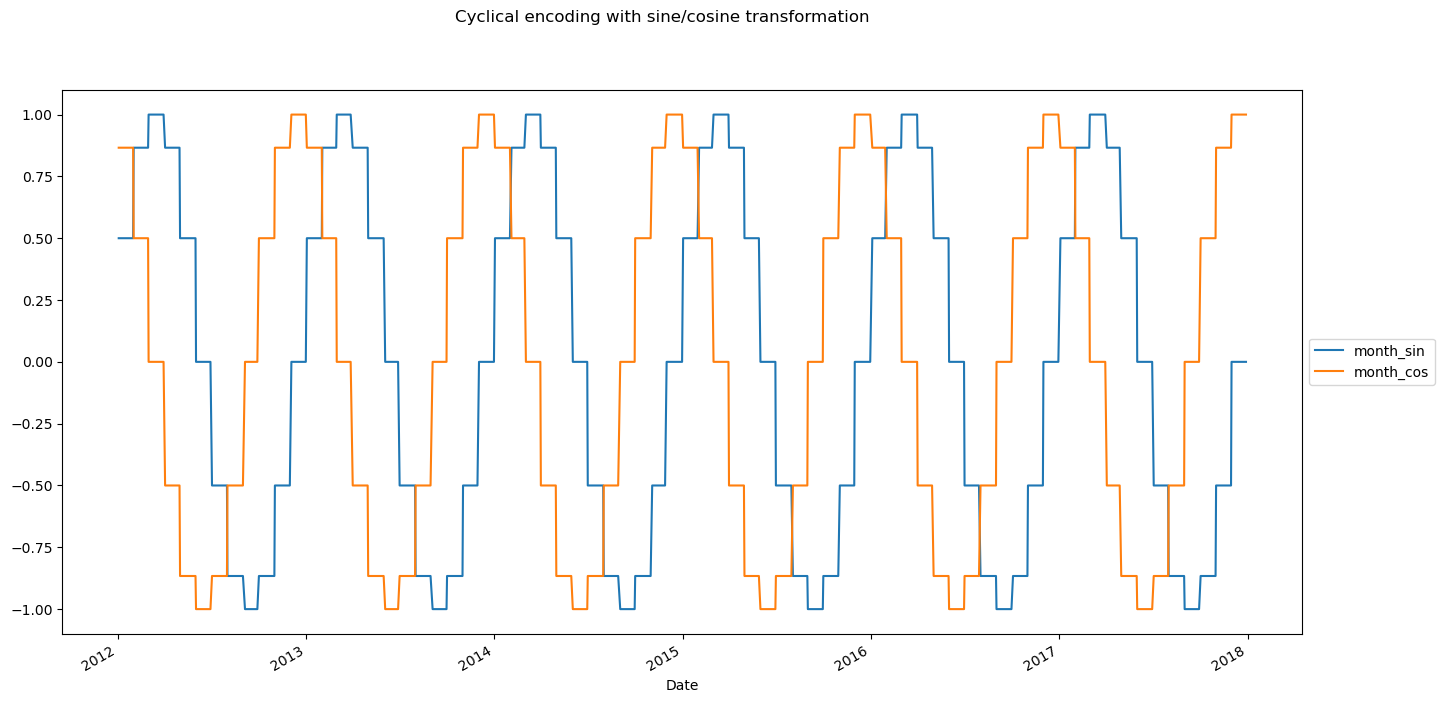

In [37]:
# Plot for only 2012-17
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(16,8))
X_2.loc["2012":"2017", ["month_sin", "month_cos"]].plot(ax=ax)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.suptitle("Cyclical encoding with sine/cosine transformation")

In [38]:
X_2.head()

,Open,Close,month,month_sin,month_cos
Date,,,,,
2000-01-03,59.03,55.50,1,0.5,0.866025
2000-01-04,54.63,52.81,1,0.5,0.866025
2000-01-05,52.75,53.06,1,0.5,0.866025
2000-01-06,52.75,53.50,1,0.5,0.866025
2000-01-07,53.75,53.63,1,0.5,0.866025


#### Calculate target (1d_future_log_rtn)
Our target is one-day future log return

In [40]:
zion["1d_future_log_rtn"] = zion["log_rtn"].shift(-1)
zion[["log_rtn", "1d_future_log_rtn"]].head()

,log_rtn,1d_future_log_rtn
Date,,
2000-01-03,NaN,-0.049682
2000-01-04,-0.049682,0.004723
2000-01-05,0.004723,0.008258
2000-01-06,0.008258,0.002427
2000-01-07,0.002427,-0.018252


#### Merge into final dataset and save

In [41]:
zion.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio',
       'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume',
       'log_rtn', 'ma14', 'rsi14', 'ma50', 'rsi50', 'ma200', 'rsi200',
       'vol_1d_change', 'vol_1d_change_ma10', '1d_future_log_rtn'],
      dtype='object')

In [42]:
zion.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2018-03-14', '2018-03-15', '2018-03-16', '2018-03-19',
               '2018-03-20', '2018-03-21', '2018-03-22', '2018-03-23',
               '2018-03-26', '2018-03-27'],
              dtype='datetime64[ns]', name='Date', length=4586, freq=None)

In [ ]:
# Merge many_shifts

In [43]:
many_shifts.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2018-03-14', '2018-03-15', '2018-03-16', '2018-03-19',
               '2018-03-20', '2018-03-21', '2018-03-22', '2018-03-23',
               '2018-03-26', '2018-03-27'],
              dtype='datetime64[ns]', name='Date', length=4586, freq=None)

In [45]:
zion_1 = pd.concat([zion, many_shifts], axis=1)

In [46]:
zion_1.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio',
       'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume',
       'log_rtn', 'ma14', 'rsi14', 'ma50', 'rsi50', 'ma200', 'rsi200',
       'vol_1d_change', 'vol_1d_change_ma10', '1d_future_log_rtn',
       'log_rtn_lag_0', 'log_rtn_lag_1', 'log_rtn_lag_2', 'log_rtn_lag_3',
       'log_rtn_lag_4', 'log_rtn_lag_5', 'log_rtn_lag_6', 'log_rtn_lag_7',
       'log_rtn_lag_8', 'log_rtn_lag_9', 'log_rtn_lag_10', 'log_rtn_lag_11',
       'log_rtn_lag_12', 'log_rtn_lag_13', 'log_rtn_lag_14'],
      dtype='object')

In [ ]:
# Merge X_2

In [47]:
X_2.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2018-03-14', '2018-03-15', '2018-03-16', '2018-03-19',
               '2018-03-20', '2018-03-21', '2018-03-22', '2018-03-23',
               '2018-03-26', '2018-03-27'],
              dtype='datetime64[ns]', name='Date', length=4586, freq=None)

In [48]:
X_2.head()

,Open,Close,month,month_sin,month_cos
Date,,,,,
2000-01-03,59.03,55.50,1,0.5,0.866025
2000-01-04,54.63,52.81,1,0.5,0.866025
2000-01-05,52.75,53.06,1,0.5,0.866025
2000-01-06,52.75,53.50,1,0.5,0.866025
2000-01-07,53.75,53.63,1,0.5,0.866025


In [50]:
zion_1 = pd.concat([zion_1, X_2[['month', 'month_sin', 'month_cos']]], axis=1)

In [51]:
zion_1.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio',
       'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume',
       'log_rtn', 'ma14', 'rsi14', 'ma50', 'rsi50', 'ma200', 'rsi200',
       'vol_1d_change', 'vol_1d_change_ma10', '1d_future_log_rtn',
       'log_rtn_lag_0', 'log_rtn_lag_1', 'log_rtn_lag_2', 'log_rtn_lag_3',
       'log_rtn_lag_4', 'log_rtn_lag_5', 'log_rtn_lag_6', 'log_rtn_lag_7',
       'log_rtn_lag_8', 'log_rtn_lag_9', 'log_rtn_lag_10', 'log_rtn_lag_11',
       'log_rtn_lag_12', 'log_rtn_lag_13', 'log_rtn_lag_14', 'month',
       'month_sin', 'month_cos'],
      dtype='object')

In [54]:
# By the end of today, we know month of next trading day. Just in predicting tomorrow return, we can use next trading day's months
zion_1['1d_future_month'] = zion_1['month'].shift(-1)
zion_1['1d_future_month_sin'] = zion_1['month_sin'].shift(-1)
zion_1['1d_future_month_cos'] = zion_1['month_cos'].shift(-1)

In [55]:
# Save to csv
zion_1.to_csv('../data/zion_1.csv')
# Made this file read-only

In [56]:
# Output data describe() here
zion_1.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,4586.0,4.247692e+01,2.022398e+01,6.380000,25.012500,4.150000e+01,5.693750e+01,8.827000e+01
High,4586.0,4.301802e+01,2.031932e+01,7.410000,25.422500,4.235500e+01,5.749500e+01,1.075900e+02
Low,4586.0,4.191482e+01,2.014377e+01,5.900000,24.617500,4.075500e+01,5.631000e+01,8.781000e+01
Close,4586.0,4.247297e+01,2.023162e+01,6.480000,25.150000,4.155000e+01,5.698000e+01,8.828000e+01
Volume,4586.0,2.218395e+06,2.280179e+06,66000.000000,544300.000000,1.655200e+06,3.035258e+06,2.633310e+07
Ex-Dividend,4586.0,2.673354e-03,2.823574e-02,0.000000,0.000000,0.000000e+00,0.000000e+00,4.300000e-01
Split Ratio,4586.0,1.000000e+00,0.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
Adj. Open,4586.0,3.815980e+01,1.705589e+01,6.109201,24.296965,3.555373e+01,4.822746e+01,7.958553e+01
Adj. High,4586.0,3.865011e+01,1.712845e+01,7.095483,24.743015,3.619438e+01,4.864645e+01,1.019509e+02
Adj. Low,4586.0,3.765131e+01,1.700249e+01,5.649575,23.827051,3.489470e+01,4.759229e+01,7.917079e+01


## 3.7) Correlation analysis

In [57]:
zion_1.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio',
       'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume',
       'log_rtn', 'ma14', 'rsi14', 'ma50', 'rsi50', 'ma200', 'rsi200',
       'vol_1d_change', 'vol_1d_change_ma10', '1d_future_log_rtn',
       'log_rtn_lag_0', 'log_rtn_lag_1', 'log_rtn_lag_2', 'log_rtn_lag_3',
       'log_rtn_lag_4', 'log_rtn_lag_5', 'log_rtn_lag_6', 'log_rtn_lag_7',
       'log_rtn_lag_8', 'log_rtn_lag_9', 'log_rtn_lag_10', 'log_rtn_lag_11',
       'log_rtn_lag_12', 'log_rtn_lag_13', 'log_rtn_lag_14', 'month',
       'month_sin', 'month_cos', '1d_future_month', '1d_future_month_sin',
       '1d_future_month_cos'],
      dtype='object')

<AxesSubplot:>

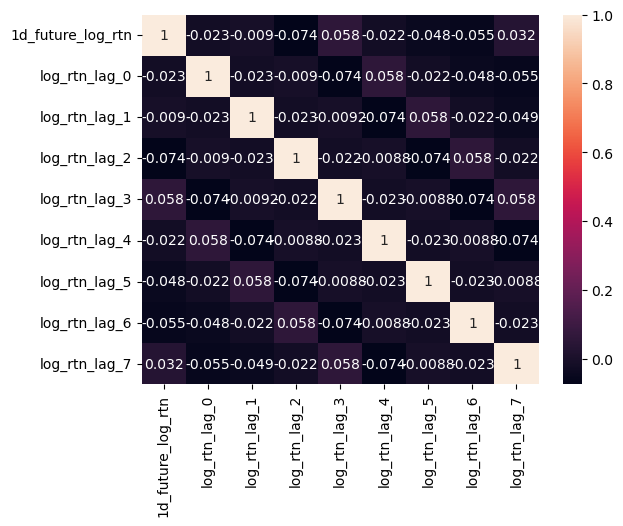

In [59]:
# col_list = ['1d_future_log_rtn', 'log_rtn_lag_0', 'log_rtn_lag_1', 'log_rtn_lag_2', 'log_rtn_lag_3',
#       'log_rtn_lag_4', 'log_rtn_lag_5', 'log_rtn_lag_6', 'log_rtn_lag_7',
#       'log_rtn_lag_8', 'log_rtn_lag_9', 'log_rtn_lag_10', 'log_rtn_lag_11',
#       'log_rtn_lag_12', 'log_rtn_lag_13', 'log_rtn_lag_14']

col_list = ['1d_future_log_rtn', 'log_rtn_lag_0', 'log_rtn_lag_1', 'log_rtn_lag_2', 'log_rtn_lag_3',
       'log_rtn_lag_4', 'log_rtn_lag_5', 'log_rtn_lag_6', 'log_rtn_lag_7']
    
sns.heatmap(zion_1[col_list].corr(), annot=True)

<AxesSubplot:>

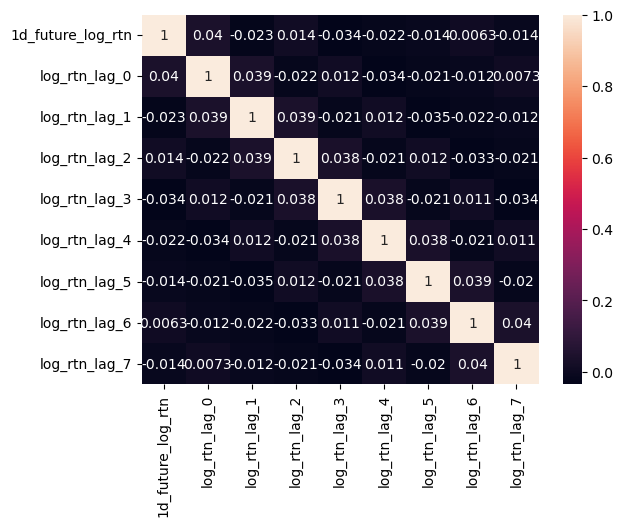

In [64]:
# For 2012-2017
col_list = ['1d_future_log_rtn', 'log_rtn_lag_0', 'log_rtn_lag_1', 'log_rtn_lag_2', 'log_rtn_lag_3',
       'log_rtn_lag_4', 'log_rtn_lag_5', 'log_rtn_lag_6', 'log_rtn_lag_7']
    
sns.heatmap(zion_1.loc['2012':'2017'][col_list].corr(), annot=True)

<AxesSubplot:>

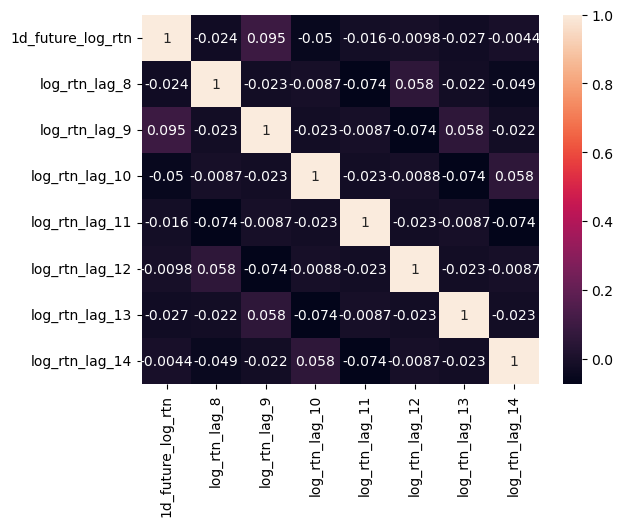

In [61]:
col_list = ['1d_future_log_rtn', 'log_rtn_lag_8', 'log_rtn_lag_9', 'log_rtn_lag_10', 'log_rtn_lag_11', 'log_rtn_lag_12',
            'log_rtn_lag_13', 'log_rtn_lag_14']
sns.heatmap(zion_1[col_list].corr(), annot=True)

<AxesSubplot:>

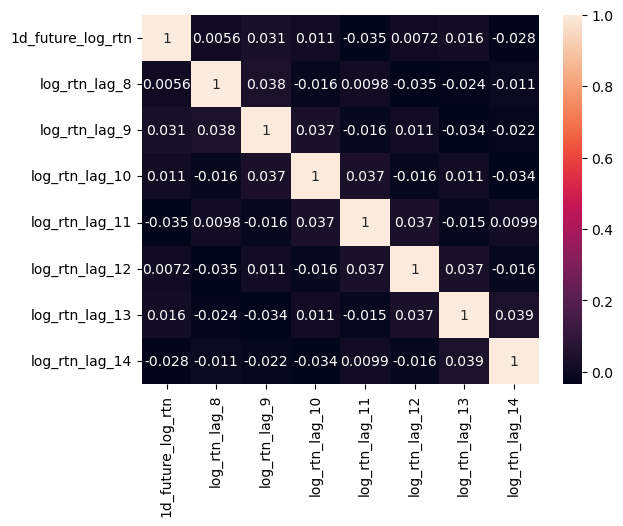

In [65]:
# 2012-17
col_list = ['1d_future_log_rtn', 'log_rtn_lag_8', 'log_rtn_lag_9', 'log_rtn_lag_10', 'log_rtn_lag_11', 'log_rtn_lag_12',
            'log_rtn_lag_13', 'log_rtn_lag_14']
sns.heatmap(zion_1.loc['2012':'2017'][col_list].corr(), annot=True)

<AxesSubplot:>

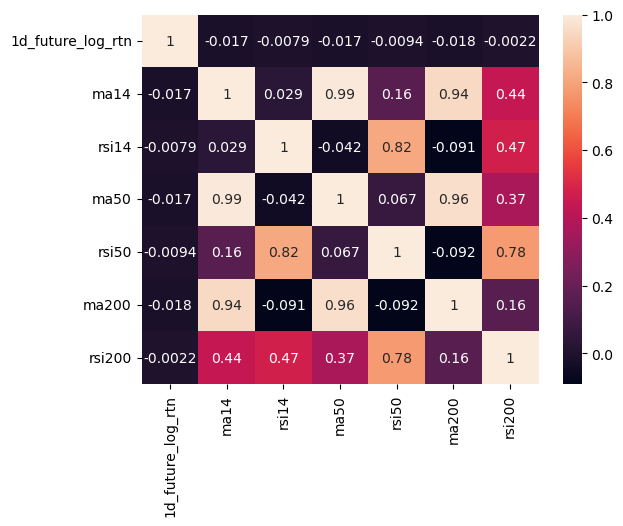

In [63]:
col_list = ['1d_future_log_rtn', 'ma14', 'rsi14', 'ma50', 'rsi50', 'ma200', 'rsi200']
sns.heatmap(zion_1[col_list].corr(), annot=True)

In [ ]:
For whole period (2000-2018)
- The technical analysis indicators have no correlation with returns.
- But they have high correlation among them. So we cannot use all of them.
- ma14 has corr of 0.99 and 0.94 with ma50 and ma200; corr(ma50, ma200)=0.96 => out of three we choose only ma50.
- rsi14 has corr of 0.82 and 0.47 with rsi50 and rsi200; corr(rsi50, rsi200) = 0.78 => we will use rsi50

<AxesSubplot:>

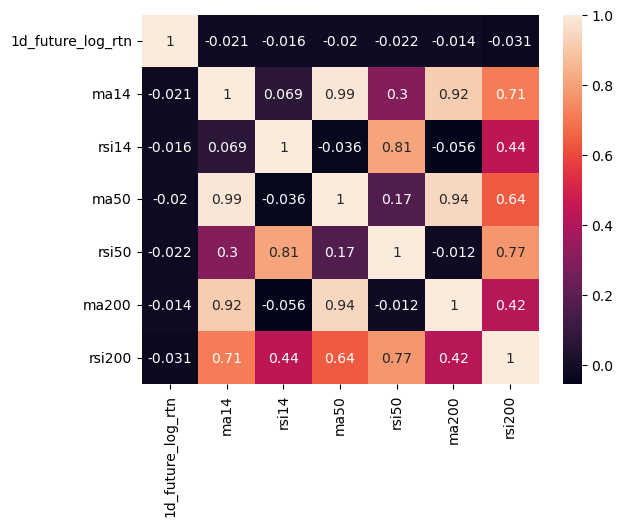

In [66]:
# 2012-17
col_list = ['1d_future_log_rtn', 'ma14', 'rsi14', 'ma50', 'rsi50', 'ma200', 'rsi200']
sns.heatmap(zion_1.loc['2012':'2017'][col_list].corr(), annot=True)

In [ ]:
For 2012-17:
- The technical analysis indicators have no correlation with returns.
- But they have high correlation among them. So we cannot use all of them.
- ma14 has corr of 0.99 and 0.92 with ma50 and ma200; corr(ma50, ma200)=0.94 => out of three we choose only ma50.
- rsi14 has corr of 0.81 and 0.44 with rsi50 and rsi200; corr(rsi50, rsi200) = 0.77 => we will use rsi50

<AxesSubplot:>

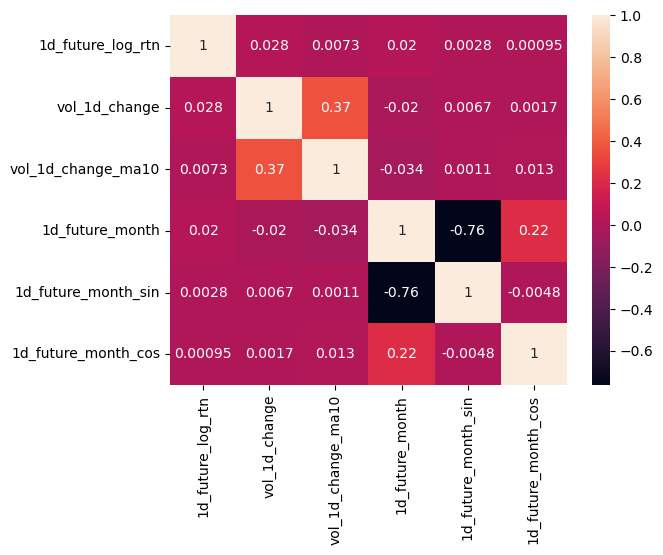

In [67]:
col_list = ['1d_future_log_rtn', 'vol_1d_change', 'vol_1d_change_ma10', '1d_future_month', '1d_future_month_sin',
       '1d_future_month_cos']
sns.heatmap(zion_1.loc['2012':'2017'][col_list].corr(), annot=True)

# Notebook ends here

# Notebook ends here

# Explore TimeseriesSplit

In [68]:
zion_1.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio',
       'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume',
       'log_rtn', 'ma14', 'rsi14', 'ma50', 'rsi50', 'ma200', 'rsi200',
       'vol_1d_change', 'vol_1d_change_ma10', '1d_future_log_rtn',
       'log_rtn_lag_0', 'log_rtn_lag_1', 'log_rtn_lag_2', 'log_rtn_lag_3',
       'log_rtn_lag_4', 'log_rtn_lag_5', 'log_rtn_lag_6', 'log_rtn_lag_7',
       'log_rtn_lag_8', 'log_rtn_lag_9', 'log_rtn_lag_10', 'log_rtn_lag_11',
       'log_rtn_lag_12', 'log_rtn_lag_13', 'log_rtn_lag_14', 'month',
       'month_sin', 'month_cos', '1d_future_month', '1d_future_month_sin',
       '1d_future_month_cos'],
      dtype='object')

In [69]:
# Take X_train and y_train 
X_train = zion_1.loc["2012":"2017"][['log_rtn_lag_0', 'log_rtn_lag_1']].copy()
y_train = zion_1.loc["2012":"2017"]['1d_future_log_rtn'].copy()
print(X_train.shape, y_train.shape)

(1508, 2) (1508,)


In [72]:
X_train.index

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
               '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               '2012-01-13', '2012-01-17',
               ...
               '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20',
               '2017-12-21', '2017-12-22', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', name='Date', length=1508, freq=None)

In [73]:
expanding_cv = TimeSeriesSplit(n_splits=5, test_size=25, max_train_size=1260)

for fold, (main_ind, valid_ind) in enumerate(expanding_cv.split(X_train)):
    print(f"Fold {fold} ----")
    print(f"Train indices: {main_ind}")
    print(f"Valid indices: {valid_ind}")

Fold 0 ----
Train indices: [ 123  124  125 ... 1380 1381 1382]
Valid indices: [1383 1384 1385 1386 1387 1388 1389 1390 1391 1392 1393 1394 1395 1396
 1397 1398 1399 1400 1401 1402 1403 1404 1405 1406 1407]
Fold 1 ----
Train indices: [ 148  149  150 ... 1405 1406 1407]
Valid indices: [1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419 1420 1421
 1422 1423 1424 1425 1426 1427 1428 1429 1430 1431 1432]
Fold 2 ----
Train indices: [ 173  174  175 ... 1430 1431 1432]
Valid indices: [1433 1434 1435 1436 1437 1438 1439 1440 1441 1442 1443 1444 1445 1446
 1447 1448 1449 1450 1451 1452 1453 1454 1455 1456 1457]
Fold 3 ----
Train indices: [ 198  199  200 ... 1455 1456 1457]
Valid indices: [1458 1459 1460 1461 1462 1463 1464 1465 1466 1467 1468 1469 1470 1471
 1472 1473 1474 1475 1476 1477 1478 1479 1480 1481 1482]
Fold 4 ----
Train indices: [ 223  224  225 ... 1480 1481 1482]
Valid indices: [1483 1484 1485 1486 1487 1488 1489 1490 1491 1492 1493 1494 1495 1496
 1497 1498 1499 1500 1501 1

In [ ]:
Explore RandomForestClassifier through Cross-Validation. Use only X_train and y_train.

In [ ]:
Explore RandomForestClassifier with Grid-search (write your own grid search)

In [ ]:
Explore RandomForestClassifier with GridSearchCV. Use only train set.

#### Modeling with exponential smoothing methods
Good to try this once we talked about teh performance evaluation methods.
The book example is to have test set = the last year. That is to forecast the whole year. For our stock rtn prediction, I would like to do one-step-ahead prediction.

#### Modeling with ARIMA
- From the book: possible rule of thumb d <= 2, p and q should not higher than 5, most likely either AR or MA will dominate leaving other to have small value of parameters.

